<div style="text-align:center;font-size:22pt; font-weight:bold;color:white;border:solid black 1.5pt;background-color:#1e7263;">
    TensorBoard Callback Overview
</div>

In [1]:
# ======================================================================= #
# Course: Deep Learning Complete Course (CS-501)
# Author: Dr. Saad Laouadi
# Institution: Quant Coding Versity Academy
#
# ==========================================================
# Lesson: Understanding tensorboard callback
#         Synthetic Data Example
# ==========================================================
# ## Learning Objectives
# This example will enable you to:
# 1. Understand the tensorboard callback
# 2. Setup the environment for using tensorboard
# =======================================================================
#          Copyright © Dr. Saad Laouadi 2025
# =======================================================================

In [ ]:
# ============================================================================ #
#                         Environment Path Configuration                       #
# ============================================================================ #
#
# Purpose:
#   Configure the system PATH to use Python executables from the active virtual 
#   environment instead of global installations.
#
# Usage:
#   1. First verify if configuration is needed by running: !which python
#   2. If the output shows the global Python installation rather than your 
#      virtual environment, execute this configuration block
#
# Note:
#   This configuration is typically only needed for JupyterLab Desktop or 
#   similar standalone installations. Web-based JupyterLab or properly 
#   configured environments should not require this adjustment.
# ============================================================================ #

import os
import sys

env_path = os.path.dirname(sys.executable)
os.environ['PATH'] = f"{env_path}:{os.environ['PATH']}"

In [19]:
# ==================================================== #
#        Load Required Libraries
# ==================================================== #

from pprint import pprint
import requests
import zipfile
import io
import shutil
from datetime import datetime
from typing import Tuple
from typing import Dict
from typing import List
from typing import Union
from typing import Optional
from typing import Type
from pathlib import Path


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.base import TransformerMixin

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score



import optuna

from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_parallel_coordinate
from optuna.visualization.matplotlib import plot_contour
from optuna.visualization.matplotlib import plot_slice
from optuna.visualization.matplotlib import plot_edf
from optuna.visualization.matplotlib import plot_rank


import tensorflow as tf

print("="*72)

%reload_ext watermark
%watermark -a "Dr. Saad Laouadi" -u -d -m

print("="*72)
print("Imported Packages and Their Versions:")
print("="*72)

%watermark -iv
print("="*72)

# Global Config
RANDOM_STATE = 101

Author: Dr. Saad Laouadi

Last updated: 2025-01-23

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Imported Packages and Their Versions:
logging   : 0.5.1.2
optuna    : 4.1.0
pandas    : 2.2.2
requests  : 2.32.3
numpy     : 1.26.4
matplotlib: 3.9.2
seaborn   : 0.13.2
tensorflow: 2.16.2
sklearn   : 1.5.1



In [20]:
# ========================================================================= #
#         Preprocessing Utility Functions
# ========================================================================= #
def load_data(filepath: Union[str, Path], sep: str = ";") -> pd.DataFrame:
    """Loads and performs initial cleaning of a CSV dataset.

    Reads a CSV file into a pandas DataFrame, converts column names to lowercase,
    and cleans whitespace from string columns. Handles both string and Path-like 
    file paths.

    Args:
        filepath: Path to the CSV file. Can be either a string or Path object.
        sep: Delimiter used in the CSV file. Defaults to semicolon.

    Returns:
        A cleaned pandas DataFrame with lowercase column names and stripped string values.

    Raises:
        FileNotFoundError: If the specified file doesn't exist.
        pd.errors.EmptyDataError: If the file is empty.
        pd.errors.ParserError: If the file cannot be parsed as CSV.

    Examples:
        >>> df = load_data("bank_marketing.csv")
        >>> df = load_data("data/marketing.csv", sep=",")
    """
    # Convert string path to Path object for better path handling
    file_path = Path(filepath)
    
    # Validate file existence
    if not file_path.exists():
        raise FileNotFoundError(f"No such file: '{file_path}'")
    
    try:
        # Read the dataset with specified separator
        df = pd.read_csv(file_path, sep=sep)
        
        # Check if DataFrame is empty
        if df.empty:
            raise pd.errors.EmptyDataError("The CSV file is empty")
        
        # Convert column names to lowercase
        df.columns = df.columns.str.lower()
        
        # Strip whitespace from string columns efficiently
        str_columns = df.select_dtypes(include=['object']).columns
        if not str_columns.empty:
            df[str_columns] = df[str_columns].apply(lambda x: x.str.strip())
        
        return df
    
    except pd.errors.ParserError as e:
        raise pd.errors.ParserError(f"Failed to parse CSV file: {e}")
        
        
def display_basic_data_info(df: pd.DataFrame) -> None:
    """Displays comprehensive overview of a pandas DataFrame.

    Prints multiple aspects of the DataFrame including shape, first rows,
    memory usage, datatypes, and statistical summary of numeric columns.

    Args:
        df (pd.DataFrame): The pandas DataFrame to analyze.

    Returns:
        None: This function prints output but does not return any value.

    Examples:
        >>> import pandas as pd
        >>> df = pd.read_csv('data.csv')
        >>> display_basic_info(df)
        ========================================================================
        Dataset Overview:
        ========================================================================
        Dataset Shape: (1000, 5)
        
        First few rows:
           col1  col2  col3
        0    1     a   1.5
        1    2     b   2.5
        ...
    """
    print("="*72)
    print("Dataset Overview:")
    print("="*72)
    print("\nDataset Shape:", df.shape)
    print("\nFirst few rows:")
    print(df.head())
    
    print("\nDataset Information:")
    print("="*72)
    df.info()
    
    print("\nStatistical Summary:")
    print("="*72)
    print(df.describe())
    

def get_feature_groups(df: pd.DataFrame, target_col: Optional[str] = 'y',
                       numeric_types: Optional[List] = None,
                       categorical_types: Optional[List] = None
                      ) -> Tuple[List[str], List[str]]:
    """Separates DataFrame features into numerical and categorical groups.
    
    Identifies and separates features into numerical and categorical groups based on their
    data types. Handles edge cases like mixed-type columns and provides options for
    custom type specifications.
    
    Args:
        df: Input DataFrame containing features to be categorized.
        target_col: Name of the target variable to exclude from feature groups.
            Defaults to 'y'. Set to None if no target should be excluded.
        numeric_types: List of numpy/pandas dtypes to consider as numeric.
            Defaults to ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'].
        categorical_types: List of numpy/pandas dtypes to consider as categorical.
            Defaults to ['object', 'category', 'bool'].
            
    Returns:
        A tuple containing:
        - List[str]: Names of numeric feature columns
        - List[str]: Names of categorical feature columns
        
    Raises:
        ValueError: If DataFrame is empty or contains no valid features.
        TypeError: If input is not a pandas DataFrame.
        
    Examples:
        >>> import pandas as pd
        >>> df = pd.DataFrame({
        ...     'age': [25, 30, 35],
        ...     'income': [50000, 60000, 75000],
        ...     'education': ['BS', 'MS', 'PhD'],
        ...     'y': [0, 1, 1]
        ... })
        >>> num_features, cat_features = get_feature_groups(df)
        >>> print(f"Numeric: {num_features}")
        Numeric: ['age', 'income']
        >>> print(f"Categorical: {cat_features}")
        Categorical: ['education']
    """
    # Input Validation
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")
    
    if df.empty:
        raise ValueError("DataFrame is empty")
            
    # Set default type lists if not provided
    if numeric_types is None:
        numeric_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    if categorical_types is None:
        categorical_types = ['object', 'category', 'bool']
        
    # Initialize feature lists
    numeric_features = []
    categorical_features = []
    
    # Categorize columns based on their types
    for column in df.columns:
        # Skip target column if specified
        if target_col and column == target_col:
            continue
            
        dtype = df[column].dtype
        # Check numeric types
        if dtype in numeric_types or (
            dtype.name in [str(t) for t in numeric_types]
        ):
            numeric_features.append(column)
        # Check categorical types
        elif dtype in categorical_types or (
            dtype.name in [str(t) for t in categorical_types]
        ):
            categorical_features.append(column)
            
        # Handle mixed types (e.g., numeric columns with missing values as objects)
        elif df[column].dtype == 'object':
            # Try to convert to numeric
            try:
                pd.to_numeric(df[column], errors='raise')
                numeric_features.append(column)
            except (ValueError, TypeError):
                categorical_features.append(column)
    
    # Verify we found some features
    if not numeric_features and not categorical_features:
        raise ValueError("No valid features found in DataFrame")
    
    return numeric_features, categorical_features

def validate_feature_separation(
    numeric_features: List[str], 
    categorical_features: List[str], 
    data: pd.DataFrame, 
    target_col: str = 'y'
) -> None:
    """Validates that all features are properly categorized.
    
    Ensures that the total number of categorized features (numeric + categorical)
    equals the total number of features in the dataset excluding the target variable.
    
    Args:
        numeric_features: List of numeric feature names.
        categorical_features: List of categorical feature names.
        data: Original pandas DataFrame containing all features.
        target_col: Name of the target column. Defaults to 'y'.
        
    Raises:
        AssertionError: If the feature count validation fails, with details about
            the mismatch.
            
    Examples:
        >>> data = pd.DataFrame({
        ...     'age': [25, 30], 
        ...     'income': [50000, 60000],
        ...     'education': ['BS', 'MS'],
        ...     'y': [0, 1]
        ... })
        >>> num_feat = ['age', 'income']
        >>> cat_feat = ['education']
        >>> validate_feature_separation(num_feat, cat_feat, data)
    """
    expected_count = len(data.columns) - 1       # Excluding target
    actual_count = len(numeric_features) + len(categorical_features)
    
    assert actual_count == expected_count, (
        f"Feature count mismatch: Found {actual_count} features "
        f"({len(numeric_features)} numeric + {len(categorical_features)} categorical) "
        f"but expected {expected_count} features. "
        f"Check for duplicates or missing features."
    )
    
    
def analyze_missing_values(df: pd.DataFrame, threshold: float = 0.0) -> pd.DataFrame:
    """Analyzes missing values in a DataFrame.
    
    Calculates comprehensive statistics about missing values in each column,
    including counts, percentages, and data types.
    
    Args:
        df (pd.DataFrame): The pandas DataFrame to analyze.
        threshold (float): Minimum percentage of missing values to include in the result.
            Defaults to 0.0 (show all missing values).
            
    Returns:
        A pandas DataFrame containing missing value analysis with columns:
            - count: Number of missing values
            - percentage: Percentage of missing values
            - dtype: Data type of the column
            - total_rows: Total number of rows in the dataset
            
    Examples:
        >>> import pandas as pd
        >>> df = pd.DataFrame({
        ...     'A': [1, None, 3],
        ...     'B': ['x', None, None],
        ...     'C': [1, 2, 3]
        ... })
        >>> missing_analysis = analyze_missing_values(df)
        >>> print(missing_analysis)
               count  percentage   dtype  total_rows
        B         2      66.67  object           3
        A         1      33.33  float64          3
        
    Notes:
        - The output is sorted by percentage of missing values in descending order
        - Only columns with missing values above the threshold are included
        - Percentages are rounded to 2 decimal places
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")
        
    if df.empty:
        raise ValueError("DataFrame is empty")
    
    # Calculate missing value statistics
    total_rows = len(df)
    
    missing_stats = pd.DataFrame({
        'count': df.isnull().sum(),
        'percentage': (df.isnull().sum() / total_rows * 100).round(2),
        'dtype': df.dtypes,
        'total_rows': total_rows
    })
    
    # Filter and sort results
    missing_filtered = missing_stats[
        missing_stats['percentage'] > threshold
    ].sort_values('percentage', ascending=False)
    
    if len(missing_filtered) > 0:
        print(f"\nFound missing values in {len(missing_filtered)} columns:")
        print(f"- Highest: {missing_filtered['percentage'].iloc[0]:.2f}% "
              f"in column '{missing_filtered.index[0]}'")
        print(f"- Total rows analyzed: {total_rows}")
    else:
        print("\n✓ No missing values found above threshold "
              f"of {threshold}% in {len(df.columns)} columns")
    
    return missing_filtered


def analyze_target_distribution(
    df: pd.DataFrame, 
    target_col: str = 'y',
    round_digits: int = 3
) -> Dict[str, Union[Dict, float]]:
    """Analyzes the distribution of the target variable in a classification dataset.
    
    Calculates class distribution, absolute counts, and imbalance metrics for
    the target variable.
    
    Args:
        df (pd.DataFrame): The input dataset containing the target variable.
        target_col (str): Name of the target column. Defaults to 'y'.
        round_digits (int): Number of decimal places for rounding. Defaults to 3.
        
    Returns:
        Dict[str, Union[Dict, float]]: A dictionary containing:
            - distribution: Proportion of each class (normalized frequencies)
            - counts: Absolute count of samples in each class
            - imbalance_ratio: Ratio of minority to majority class frequency
            - majority_class: Label of the majority class
            - minority_class: Label of the minority class
            
    Raises:
        KeyError: If target_col is not found in the DataFrame.
        ValueError: If DataFrame is empty or target contains invalid values.
            
    Examples:
        >>> df = pd.DataFrame({'y': [0, 0, 0, 1, 1]})
        >>> result = analyze_target_distribution(df)
        >>> print(result)
        {
            'distribution': {0: 0.6, 1: 0.4},
            'counts': {0: 3, 1: 2},
            'imbalance_ratio': 0.667,
            'majority_class': 0,
            'minority_class': 1
        }
    """
    # Input validation
    if target_col not in df.columns:
        raise KeyError(f"Target column '{target_col}' not found in DataFrame")
    
    if df.empty:
        raise ValueError("DataFrame is empty")
        
    if df[target_col].isnull().any():
        raise ValueError("Target variable contains missing values")
    
    # Calculate distributions and counts
    target_counts = df[target_col].value_counts()
    target_dist = target_counts / len(df)
    
    # Identify majority and minority classes
    majority_class = target_counts.idxmax()
    minority_class = target_counts.idxmin()
    
    # Calculate imbalance ratio
    imbalance_ratio = float(target_counts.min()) / float(target_counts.max())
    
    # Prepare results
    results = {
        'distribution': {k: round(float(v), round_digits) 
                        for k, v in target_dist.to_dict().items()},
        'counts': target_counts.to_dict(),
        'imbalance_ratio': round(imbalance_ratio, round_digits),
        'majority_class': majority_class,
        'minority_class': minority_class
    }
    
    # Print summary
    print("\nTarget Distribution Analysis:")
    print(f"✓ Total samples: {len(df)}")
    print(f"✓ Number of classes: {len(target_counts)}")
    print(f"✓ Majority class ({majority_class}): {target_counts.max()} samples "
          f"({target_dist.max():.1%})")
    print(f"✓ Minority class ({minority_class}): {target_counts.min()} samples "
          f"({target_dist.min():.1%})")
    print(f"✓ Imbalance ratio: {imbalance_ratio:.3f}")
    
    return results


def plot_target_distribution(
    df: pd.DataFrame,
    target_col: str = 'y',
    figsize: Tuple[int, int] = (10, 6),
    title_fontsize: int = 12,
    label_fontsize: int = 10,
    palette: str = 'viridis',
    rotation: int = 0
) -> None:
    """Creates a visualization of target variable distribution.
    
    Generates a bar plot showing the distribution of classes in the target variable,
    including count and percentage labels.
    
    Args:
        df (pd.DataFrame): The input dataset containing the target variable.
        target_col (str): Name of the target column. Defaults to 'y'.
        figsize (Tuple[int, int]): Figure size as (width, height). Defaults to (10, 6).
        title_fontsize (int): Font size for the title. Defaults to 12.
        label_fontsize (int): Font size for labels. Defaults to 10.
        palette (str): Color palette for the plot. Defaults to 'viridis'.
        rotation (int): Rotation angle for x-axis labels. Defaults to 0.
        
    Raises:
        KeyError: If target_col is not found in the DataFrame.
        ValueError: If DataFrame is empty or target contains invalid values.
        
    Example:
        >>> df = pd.DataFrame({'y': [0, 0, 0, 1, 1]})
        >>> plot_target_distribution(df)
    """
    # Input validation
    if target_col not in df.columns:
        raise KeyError(f"Target column '{target_col}' not found in DataFrame")
    
    if df.empty:
        raise ValueError("DataFrame is empty")
    
    # Calculate distribution
    target_counts = df[target_col].value_counts()
    target_percentages = (target_counts / len(df) * 100).round(1)
    
    # Create figure and axis
    plt.figure(figsize=figsize)
    
    # Create bar plot
    ax = sns.barplot(
        x=target_counts.index,
        y=target_counts.values,
        hue=target_counts.index,  # Add hue parameter
        palette=palette,
        legend=False  # Hide legend since we don't need it
    )
    
    # Add count and percentage labels on bars
    for i, (count, percentage) in enumerate(zip(target_counts, target_percentages)):
        ax.text(
            i, count/2,
            f'n = {count}\n({percentage}%)',
            ha='center',
            va='center',
            fontsize=label_fontsize,
            color='white',
            fontweight='bold'
        )
    
    # Customize plot
    plt.title(
        f'Distribution of {target_col}\n(Total samples: {len(df)})',
        fontsize=title_fontsize,
        pad=20
    )
    plt.xlabel(f'{target_col} Classes', fontsize=label_fontsize)
    plt.ylabel('Count', fontsize=label_fontsize)
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=rotation)
    
    # Add grid for better readability
    plt.grid(True, axis='y', alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()
    

def generate_data_summary(df: pd.DataFrame,
                          target_col: str = 'y'
                         ) -> Dict[str, Union[Tuple, Dict]]:
    """Generates a comprehensive summary of the dataset features and characteristics.
   
    Creates a detailed summary including dataset dimensions, feature types,
    descriptive statistics, target distribution, and missing value analysis.
   
    Args:
        df (pd.DataFrame): The input dataset to analyze.
        target_col (str): Name of the target column. Defaults to 'y'.
   
    Returns:
        Dict[str, Union[Tuple, Dict]]: A dictionary containing:
            - dataset_shape: Tuple of (rows, columns)
            - numeric_features: Dict with:
                - count: Number of numeric features
                - names: List of numeric feature names
                - statistics: Basic statistics (mean, std, min, max, etc.)
            - categorical_features: Dict with:
                - count: Number of categorical features
                - names: List of categorical feature names
                - unique_values: Count of unique values per feature
            - target_distribution: Distribution analysis of target variable
            - missing_values: Analysis of missing values by feature
           
    Raises:
        ValueError: If DataFrame is empty or contains invalid data.
        KeyError: If target_col is not found in DataFrame.
           
    Examples:
        >>> df = pd.DataFrame({
        ...     'age': [25, 30, 35],
        ...     'salary': [50000, 60000, 70000],
        ...     'department': ['HR', 'IT', 'HR'],
        ...     'y': [0, 1, 1]
        ... })
        >>> summary = generate_data_summary(df)
        >>> print(f"Dataset shape: {summary['dataset_shape']}")
        >>> print(f"Number of numeric features: {summary['numeric_features']['count']}")
    """
    # Input validation
    if df.empty:
        raise ValueError("DataFrame is empty")
        
    if target_col not in df.columns:
        raise KeyError(f"Target column '{target_col}' not found in DataFrame")

    # Get feature groups
    numeric_features, categorical_features = get_feature_groups(df)
   
    # Generate summary dictionary
    summary = {
       'dataset_shape': df.shape,
       'numeric_features': {
           'count': len(numeric_features),
           'names': numeric_features,
           'statistics': df[numeric_features].describe().round(2).to_dict()
       },
       'categorical_features': {
           'count': len(categorical_features),
           'names': categorical_features,
           'unique_values': {col: df[col].nunique() for col in categorical_features},
           'value_counts': {col: df[col].value_counts().to_dict() 
                          for col in categorical_features}
       },
       'target_distribution': analyze_target_distribution(df, target_col=target_col),
       'missing_values': analyze_missing_values(df).to_dict()
    }
   
    # Print summary overview
    print("\nDataset Summary:")
    print(f"✓ Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"✓ Numeric Features: {len(numeric_features)}")
    print(f"✓ Categorical Features: {len(categorical_features)}")
    print(f"✓ Missing Values: {df.isnull().sum().sum()} total")
    print(f"✓ Memory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

    return summary


def preprocess_numeric_features(df: pd.DataFrame,
                                numeric_features: List[str],
                                scaler_type: Union[Type[TransformerMixin], None] = StandardScaler,
                                copy: bool = True
                               ) -> Tuple[pd.DataFrame, TransformerMixin]:
    """Preprocesses numerical features using specified scaling method.

    Scales numerical features using a specified scaler (StandardScaler by default).
    Supports any sklearn-compatible scaler and preserves the original DataFrame structure.

    Args:
       df (pd.DataFrame): The input dataset containing features to scale.
       numeric_features (List[str]): List of numerical column names to scale.
       scaler_type (Union[Type[TransformerMixin], None], optional): Sklearn scaler class to use.
           Defaults to StandardScaler. Set to None to return data without scaling.
       copy (bool, optional): Whether to create a copy of the input DataFrame.
           Defaults to True to preserve the original data.

    Returns:
       Tuple[pd.DataFrame, TransformerMixin]: A tuple containing:
           - pd.DataFrame: The preprocessed dataset with scaled features
           - TransformerMixin: The fitted scaler object for later use

    Raises:
       ValueError: If numeric_features is empty or contains invalid column names.
       TypeError: If scaler_type is not a valid sklearn transformer.

    Examples:
       >>> from sklearn.preprocessing import MinMaxScaler
       >>> df = pd.DataFrame({
       ...     'age': [25, 30, 35],
       ...     'salary': [50000, 60000, 70000],
       ...     'category': ['A', 'B', 'C']
       ... })
       >>> numeric_cols = ['age', 'salary']
       >>> scaled_df, scaler = preprocess_numeric_features(
       ...     df, 
       ...     numeric_cols,
       ...     scaler_type=MinMaxScaler
       ... )

    Notes:
       - The scaler is fitted on the training data and can be reused for test data
       - Original DataFrame structure and non-numeric columns are preserved
       - Common scalers: StandardScaler, MinMaxScaler, RobustScaler
    """
    # Input validation
    if not numeric_features:
        raise ValueError("numeric_features list cannot be empty")

    if not all(col in df.columns for col in numeric_features):
        missing_cols = [col for col in numeric_features if col not in df.columns]
        raise ValueError(f"Columns not found in DataFrame: {missing_cols}")

    if scaler_type is not None and not issubclass(scaler_type, TransformerMixin):
        raise TypeError("scaler_type must be a valid sklearn transformer")

    # Create copy if requested
    df_processed = df.copy() if copy else df

    if scaler_type is not None:
        # Initialize and fit scaler
        scaler = scaler_type()
        
        # Scale features
        try:
            df_processed[numeric_features] = scaler.fit_transform(
                df[numeric_features]
            )
            
            # Print scaling summary
            print("\nFeature Scaling Summary:")
            print(f"✓ Scaler: {scaler_type.__name__}")
            print(f"✓ Features scaled: {len(numeric_features)}")

            if isinstance(scaler, StandardScaler):
                print("\nScaling Parameters:")
                print("- Mean:", dict(zip(numeric_features, 
                                       scaler.mean_.round(4))))
                print("- Std:", dict(zip(numeric_features, 
                                      scaler.scale_.round(4))))
            elif isinstance(scaler, MinMaxScaler):
                print("\nScaling Parameters:")
                print("- Min:", dict(zip(numeric_features, 
                                      scaler.data_min_.round(4))))
                print("- Max:", dict(zip(numeric_features, 
                                      scaler.data_max_.round(4))))
        except Exception as e: 
            raise ValueError(f"Error during scaling: {str(e)}")
    else:
        scaler = None
        print("\n✓ No scaling applied - returning original features")

    return df_processed, scaler


def encode_categorical_features(
    df: pd.DataFrame,
    categorical_features: List[str],
    drop: str = 'if_binary',
    handle_unknown: str = 'ignore',
    sparse_output: bool = False,
    copy: bool = True,
    min_frequency: Optional[float] = None
) -> Tuple[pd.DataFrame, OneHotEncoder, Dict[str, Dict]]:
    """Encodes categorical features using OneHotEncoder with advanced options and diagnostics.
    
    Performs one-hot encoding on specified categorical features with configurable handling
    of rare categories, unknown values, and binary features. Includes detailed encoding
    statistics and validation.
    
    Args:
        df (pd.DataFrame): Input dataset containing features to encode.
        categorical_features (List[str]): List of categorical column names to encode.
        drop (str, optional): Strategy to drop columns. Options:
            - 'if_binary': Drop first category for binary features only
            - 'first': Always drop first category
            - None: Keep all categories
            Defaults to 'if_binary'.
        handle_unknown (str, optional): Strategy for unknown categories in transform.
            Options: 'error', 'ignore'. Defaults to 'ignore'.
        sparse_output (bool, optional): Whether to return sparse matrix.
            Defaults to False.
        copy (bool, optional): Whether to copy the input DataFrame.
            Defaults to True.
        min_frequency (float, optional): Minimum frequency for category inclusion.
            Categories below this threshold will be grouped into 'rare'.
            If None, keep all categories. Defaults to None.
            
    Returns:
        Tuple[pd.DataFrame, OneHotEncoder, Dict[str, Dict]]: A tuple containing:
            - pd.DataFrame: The preprocessed dataset with encoded features
            - OneHotEncoder: The fitted encoder object for later use
            - Dict[str, Dict]: Encoding statistics and diagnostics
            
    Raises:
        ValueError: If categorical_features is empty or contains invalid columns.
        TypeError: If input types are invalid.
        
    Examples:
        >>> df = pd.DataFrame({
        ...     'color': ['red', 'blue', 'red', 'green'],
        ...     'size': ['S', 'M', 'L', 'S'],
        ...     'value': [10, 20, 30, 40]
        ... })
        >>> cat_features = ['color', 'size']
        >>> encoded_df, encoder, stats = encode_categorical_features(
        ...     df, 
        ...     cat_features,
        ...     min_frequency=0.2
        ... )
        >>> print("Encoded features:", stats['encoded_features'])
        >>> print("Category frequencies:", stats['category_frequencies'])
    """
    # Input validation
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame")
        
    if not categorical_features:
        raise ValueError("categorical_features list cannot be empty")
        
    if not all(isinstance(col, str) for col in categorical_features):
        raise TypeError("All feature names must be strings")
        
    if not all(col in df.columns for col in categorical_features):
        missing_cols = [col for col in categorical_features if col not in df.columns]
        raise ValueError(f"Columns not found in DataFrame: {missing_cols}")
        
    # Create copy if requested
    df_encoded = df.copy() if copy else df
    
    # Calculate category frequencies for each feature
    category_frequencies = {
        col: df[col].value_counts(normalize=True).to_dict()
        for col in categorical_features
    }
    
    # Handle rare categories if min_frequency is specified
    if min_frequency is not None:
        for col in categorical_features:
            rare_categories = [
                cat for cat, freq in category_frequencies[col].items()
                if freq < min_frequency
            ]
            if rare_categories:
                df_encoded[col] = df_encoded[col].replace(
                    rare_categories, 'rare'
                )
    
    # Initialize and fit encoder
    encoder = OneHotEncoder(
        sparse_output=sparse_output,
        handle_unknown=handle_unknown,
        drop=drop
    )
    
    try:
        # Fit and transform the categorical features
        encoded_features = encoder.fit_transform(df_encoded[categorical_features])
        feature_names = encoder.get_feature_names_out(categorical_features)
        
        # Create DataFrame with encoded features
        encoded_df = pd.DataFrame(
            encoded_features,
            columns=feature_names,
            index=df_encoded.index
        )
        
        # Drop original categorical columns and concatenate encoded features
        df_encoded = df_encoded.drop(columns=categorical_features)
        df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
        
    except Exception as e:
        raise ValueError(f"Error during encoding: {str(e)}")
    
    # Compile encoding statistics
    encoding_stats = {
        'encoded_features': feature_names.tolist(),
        'original_features': categorical_features,
        'category_frequencies': category_frequencies,
        'categories_per_feature': {
            col: len(encoder.categories_[i])
            for i, col in enumerate(categorical_features)
        },
        'total_features_created': len(feature_names),
        'memory_impact': {
            'original_size': df[categorical_features].memory_usage().sum() / 1024**2,
            'encoded_size': encoded_df.memory_usage().sum() / 1024**2
        }
    }
    
    # Print encoding summary
    print("\nCategorical Encoding Summary:")
    print(f"✓ Features encoded: {len(categorical_features)}")
    print(f"✓ Original categories: {sum(len(cats) for cats in encoder.categories_)}")
    print(f"✓ Encoded features created: {len(feature_names)}")
    if min_frequency is not None:
        print(f"✓ Minimum category frequency: {min_frequency}")
    print(f"✓ Memory impact: {encoding_stats['memory_impact']['encoded_size']:.2f}MB "
          f"(was {encoding_stats['memory_impact']['original_size']:.2f}MB)")
    
    return df_encoded, encoder, encoding_stats


from typing import Tuple, Dict, Any, Optional
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import logging
from datetime import datetime

def encode_target(
    df: pd.DataFrame,
    target_column: str,
    drop_na: bool = False,
    handle_unknown: str = 'error'
) -> Tuple[pd.DataFrame, LabelEncoder, Dict[str, Any]]:
    """
    Encodes the target variable using LabelEncoder with enhanced error handling and validation.
    
    This function performs robust target variable encoding with comprehensive input validation,
    error handling, and detailed logging. It supports handling of missing values and provides
    detailed statistics about the encoding process.
    
    Args:
        df (pd.DataFrame): Input dataset containing the target variable.
        target_column (str): Name of the target column to encode.
        drop_na (bool, optional): If True, drops rows with NA values in target.
            If False, raises error if NA values found. Defaults to False.
        handle_unknown (str, optional): How to handle unknown categories during transform.
            Options: 'error' (raise error) or 'ignore' (keep as NA). Defaults to 'error'.
            
    Returns:
        Tuple[pd.DataFrame, LabelEncoder, Dict[str, Any]]: A tuple containing:
            - DataFrame with encoded target variable
            - Fitted LabelEncoder instance for future use
            - Dictionary with encoding metadata and statistics
            
    Raises:
        ValueError: If input validation fails or invalid parameters provided
        TypeError: If input types are incorrect
        KeyError: If target_column not found in DataFrame
        
    Example:
        >>> df = pd.DataFrame({'target': ['yes', 'no', 'yes', 'maybe']})
        >>> encoded_df, encoder, stats = encode_target(df, 'target')
        >>> print(f"Encoded values: {encoded_df['target'].tolist()}")
        >>> print(f"Original classes: {encoder.classes_}")
        >>> print(f"Encoding stats: {stats}")
        
    Notes:
        - The function preserves the original index of the DataFrame
        - Handles edge cases like single-class targets and empty DataFrames
        - Provides detailed statistics about the encoding process
        - Thread-safe and suitable for production environments
    """
    # Set up logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
    logger = logging.getLogger(__name__)
    
    # Initialize metadata dictionary
    metadata = {
        'timestamp': datetime.now().isoformat(),
        'original_shape': df.shape,
        'target_column': target_column,
        'dropped_na': 0,
        'unique_classes': 0,
        'class_distribution': {},
        'warnings': []
    }
    
    try:
        # Input validation
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input 'df' must be a pandas DataFrame")
        
        if not isinstance(target_column, str):
            raise TypeError("'target_column' must be a string")
            
        if target_column not in df.columns:
            raise KeyError(f"Target column '{target_column}' not found in DataFrame")
            
        if df.empty:
            raise ValueError("Input DataFrame is empty")
            
        # Create a copy to avoid modifying original data
        df_encoded = df.copy()
        
        # Handle missing values
        na_mask = df_encoded[target_column].isna()
        na_count = na_mask.sum()
        
        if na_count > 0:
            message = f"Found {na_count} missing values in target column"
            if drop_na:
                df_encoded = df_encoded[~na_mask]
                metadata['dropped_na'] = na_count
                metadata['warnings'].append(f"{message} - dropped")
                logger.warning(f"{message} - dropping rows")
            else:
                raise ValueError(f"{message}. Set drop_na=True to drop them")
        
        # Check for single class
        unique_classes = df_encoded[target_column].unique()
        if len(unique_classes) < 2:
            raise ValueError(
                f"Target column contains only {len(unique_classes)} unique class(es). "
                "Need at least 2 classes for encoding."
            )
        
        # Initialize and fit encoder
        encoder = LabelEncoder()
        
        # Fit transform the target
        df_encoded[target_column] = encoder.fit_transform(df_encoded[target_column])
        
        # Gather encoding statistics
        class_counts = df[target_column].value_counts()
        metadata.update({
            'unique_classes': len(encoder.classes_),
            'class_distribution': class_counts.to_dict(),
            'class_mapping': dict(zip(encoder.classes_, range(len(encoder.classes_)))),
            'final_shape': df_encoded.shape
        })
        
        logger.info(
            f"Successfully encoded {target_column} "
            f"({len(encoder.classes_)} classes)"
        )
        
        return df_encoded, encoder, metadata
        
    except Exception as e:
        logger.error(f"Error encoding target: {str(e)}")
        raise
        
def decode_target_values(
    encoded_values: np.ndarray,
    encoder: LabelEncoder,
    handle_unknown: str = 'error'
) -> np.ndarray:
    """
    Decodes previously encoded target values back to original labels.
    
    Args:
        encoded_values (np.ndarray): Array of encoded target values
        encoder (LabelEncoder): Fitted LabelEncoder instance
        handle_unknown (str, optional): How to handle unknown values.
            Options: 'error' or 'ignore'. Defaults to 'error'.
            
    Returns:
        np.ndarray: Array of decoded original labels
        
    Raises:
        ValueError: If unknown values found and handle_unknown='error'
    """
    try:
        return encoder.inverse_transform(encoded_values)
    except Exception as e:
        if handle_unknown == 'ignore':
            # Return array with NaN for unknown values
            result = np.empty(encoded_values.shape, dtype=object)
            result[:] = np.nan
            mask = (encoded_values >= 0) & (encoded_values < len(encoder.classes_))
            result[mask] = encoder.inverse_transform(encoded_values[mask])
            return result
        else:
            raise ValueError(f"Error decoding values: {str(e)}")

In [28]:
         
from typing import List, Optional, Dict, Any, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import logging
from math import ceil


import contextlib
import logging

@contextlib.contextmanager
def suppress_matplotlib_categorical_warning():
    """Context manager to temporarily suppress matplotlib categorical plotting warning."""
    matplotlib_logger = logging.getLogger('matplotlib.category')
    
    # Define our filter
    class SuppressWarning(logging.Filter):
        def filter(self, record):
            return not record.getMessage().startswith(
                'Using categorical units to plot a list of strings'
            )
    
    # Add the filter and store it
    warning_filter = SuppressWarning()
    matplotlib_logger.addFilter(warning_filter)
    
    try:
        yield
    finally:
        # Always remove the filter after we're done
        matplotlib_logger.removeFilter(warning_filter)

def init_logging():
    class SuppressMatplotlibInfo(logging.Filter):
        def filter(self, record):
            return (
                """Using categorical units to plot a list of strings that are all 
                parsable as floats or dates. If these strings should be plotted as numbers,
                cast to the appropriate data type before plotting.
                """ != record.getMessage()
            )
 
    logging.basicConfig(level=logging.INFO)
    matplotlib_logger = logging.getLogger("matplotlib.category")
    matplotlib_logger.addFilter(SuppressMatplotlibInfo())
    
import warnings

def suppress_matplotlib_warning():
    """Suppress specific matplotlib categorical plotting warning."""
    warnings.filterwarnings(
        'ignore',
        category=UserWarning,
        message='Using categorical units to plot a list of strings.*'
    )
    
def plot_numeric_distributions(
    df: pd.DataFrame,
    numeric_features: List[str],
    target_col: str = 'y',
    figsize: tuple = (15, 10),
    n_cols: int = 2,
    plot_type: str = 'both',
    palette: str = 'viridis',
    title_fontsize: int = 12,
    label_fontsize: int = 10,
    show_stats: bool = True,
    max_unique_targets: int = 10
) -> Optional[Dict[str, Any]]:
    """
    Creates professional visualization of numeric feature distributions with respect to target variable.
    
    This function generates either box plots, violin plots, or both for each numeric feature,
    showing their distribution across different target classes. It automatically handles
    plot layout and removes empty subplots.
    
    Args:
        df: Input DataFrame containing features and target
        numeric_features: List of numerical feature names to plot
        target_col: Name of target column (default: 'y')
        figsize: Figure size as (width, height) tuple (default: (15, 10))
        n_cols: Number of columns in subplot grid (default: 2)
        plot_type: Type of plot to create: 'box', 'violin', or 'both' (default: 'both')
        palette: Color palette for plots (default: 'viridis')
        title_fontsize: Font size for subplot titles (default: 12)
        label_fontsize: Font size for axis labels (default: 10)
        show_stats: Whether to show basic statistics on plots (default: True)
        max_unique_targets: Maximum number of unique target values to allow (default: 10)
        
    Returns:
        Optional[Dict[str, Any]]: Dictionary containing plot statistics if show_stats=True
        
    Raises:
        ValueError: If input validation fails
        KeyError: If features or target column not found in DataFrame
        
    Example:
        >>> df = pd.DataFrame({
        ...     'feature1': np.random.normal(0, 1, 1000),
        ...     'feature2': np.random.normal(2, 1.5, 1000),
        ...     'y': np.random.choice([0, 1], 1000)
        ... })
        >>> plot_numeric_distributions(df, ['feature1', 'feature2'])
    """
    # Set up logging
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    
    try:
        # Input validation
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input 'df' must be a pandas DataFrame")
            
        if not numeric_features:
            raise ValueError("numeric_features list cannot be empty")
            
        if not all(col in df.columns for col in numeric_features):
            missing = [col for col in numeric_features if col not in df.columns]
            raise KeyError(f"Features not found in DataFrame: {missing}")
            
        if target_col not in df.columns:
            raise KeyError(f"Target column '{target_col}' not found in DataFrame")
            
        # Check number of unique target values
        n_unique_targets = df[target_col].nunique()
        if n_unique_targets > max_unique_targets:
            raise ValueError(
                f"Too many unique target values ({n_unique_targets}). "
                f"Maximum allowed is {max_unique_targets}"
            )
            
        # Calculate layout
        n_features = len(numeric_features)
        n_rows = ceil(n_features / n_cols)
        
        # Adjust figure size based on number of rows
        height_per_row = figsize[1] / 2  # Base height per row
        adjusted_figsize = (figsize[0], height_per_row * n_rows)
        
        # Create figure and GridSpec
        fig = plt.figure(figsize=adjusted_figsize)
        gs = GridSpec(n_rows, n_cols, figure=fig)
        
        # Store statistics if requested
        stats = {} if show_stats else None
        
        # Create plots
        for idx, feature in enumerate(numeric_features):
            row = idx // n_cols
            col = idx % n_cols
            ax = fig.add_subplot(gs[row, col])
            
            # Create plots based on type
            if plot_type in ['box', 'both']:
                sns.boxplot(
                    x=target_col,
                    y=feature,
                    data=df,
                    hue=target_col,
                    palette=palette,
                    ax=ax,
                    legend=False
                )
            
            if plot_type in ['violin', 'both']:
                if plot_type == 'both':
                    ax2 = ax.twinx()  # Create twin axis for violin plot
                    sns.violinplot(
                        x=target_col,
                        y=feature,
                        data=df,
                        hue =target_col,
                        palette=palette,
                        alpha=0.3,
                        ax=ax2,
                        legend=False
                    )
                    ax2.set_ylabel('')  # Remove redundant ylabel
                else:
                    sns.violinplot(
                        x=target_col,
                        y=feature,
                        data=df,
                        hue=target_col,
                        palette=palette,
                        ax=ax,
                        legend=False
                    )
            
            # Add title and labels
            ax.set_title(
                f'Distribution of {feature} by {target_col}',
                fontsize=title_fontsize,
                pad=10
            )
            ax.set_xlabel(target_col, fontsize=label_fontsize)
            ax.set_ylabel(feature, fontsize=label_fontsize)
            
            # Add statistics if requested
            if show_stats:
                stats[feature] = {
                    'mean': df[feature].mean(),
                    'std': df[feature].std(),
                    'by_target': df.groupby(target_col)[feature].agg(['mean', 'std']).to_dict()
                }
                
                # Add stats to plot
                stat_text = f"μ={stats[feature]['mean']:.2f}\nσ={stats[feature]['std']:.2f}"
                ax.text(
                    0.95, 0.95, stat_text,
                    transform=ax.transAxes,
                    verticalalignment='top',
                    horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
                )
        
        # Remove empty subplots
        for idx in range(len(numeric_features), n_rows * n_cols):
            row = idx // n_cols
            col = idx % n_cols
            fig.delaxes(fig.add_subplot(gs[row, col]))
        
        # Adjust layout
        plt.tight_layout()
        
        # Log success
        logger.info(
            f"Successfully created distribution plots for {len(numeric_features)} features"
        )
        
        return stats
        
    except Exception as e:
        logger.error(f"Error creating distribution plots: {str(e)}")
        raise

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should


Feature Statistics:

feature1:
Overall mean: 0.02
Overall std: 0.98
By target class:
  Class mean: {0: -0.026940912654873674, 1: 0.06308431784551381}
  Class std: {0: 0.9367204402004112, 1: 1.0167405101088203}

feature2:
Overall mean: 2.02
Overall std: 2.01
By target class:
  Class mean: {0: 1.9760396690193713, 1: 2.0537287709150207}
  Class std: {0: 1.9160614368141136, 1: 2.088600729762068}

feature3:
Overall mean: -0.01
Overall std: 0.58
By target class:
  Class mean: {0: -0.008510444649177924, 1: -0.013373446489256991}
  Class std: {0: 0.571970489542575, 1: 0.5838813327584684}


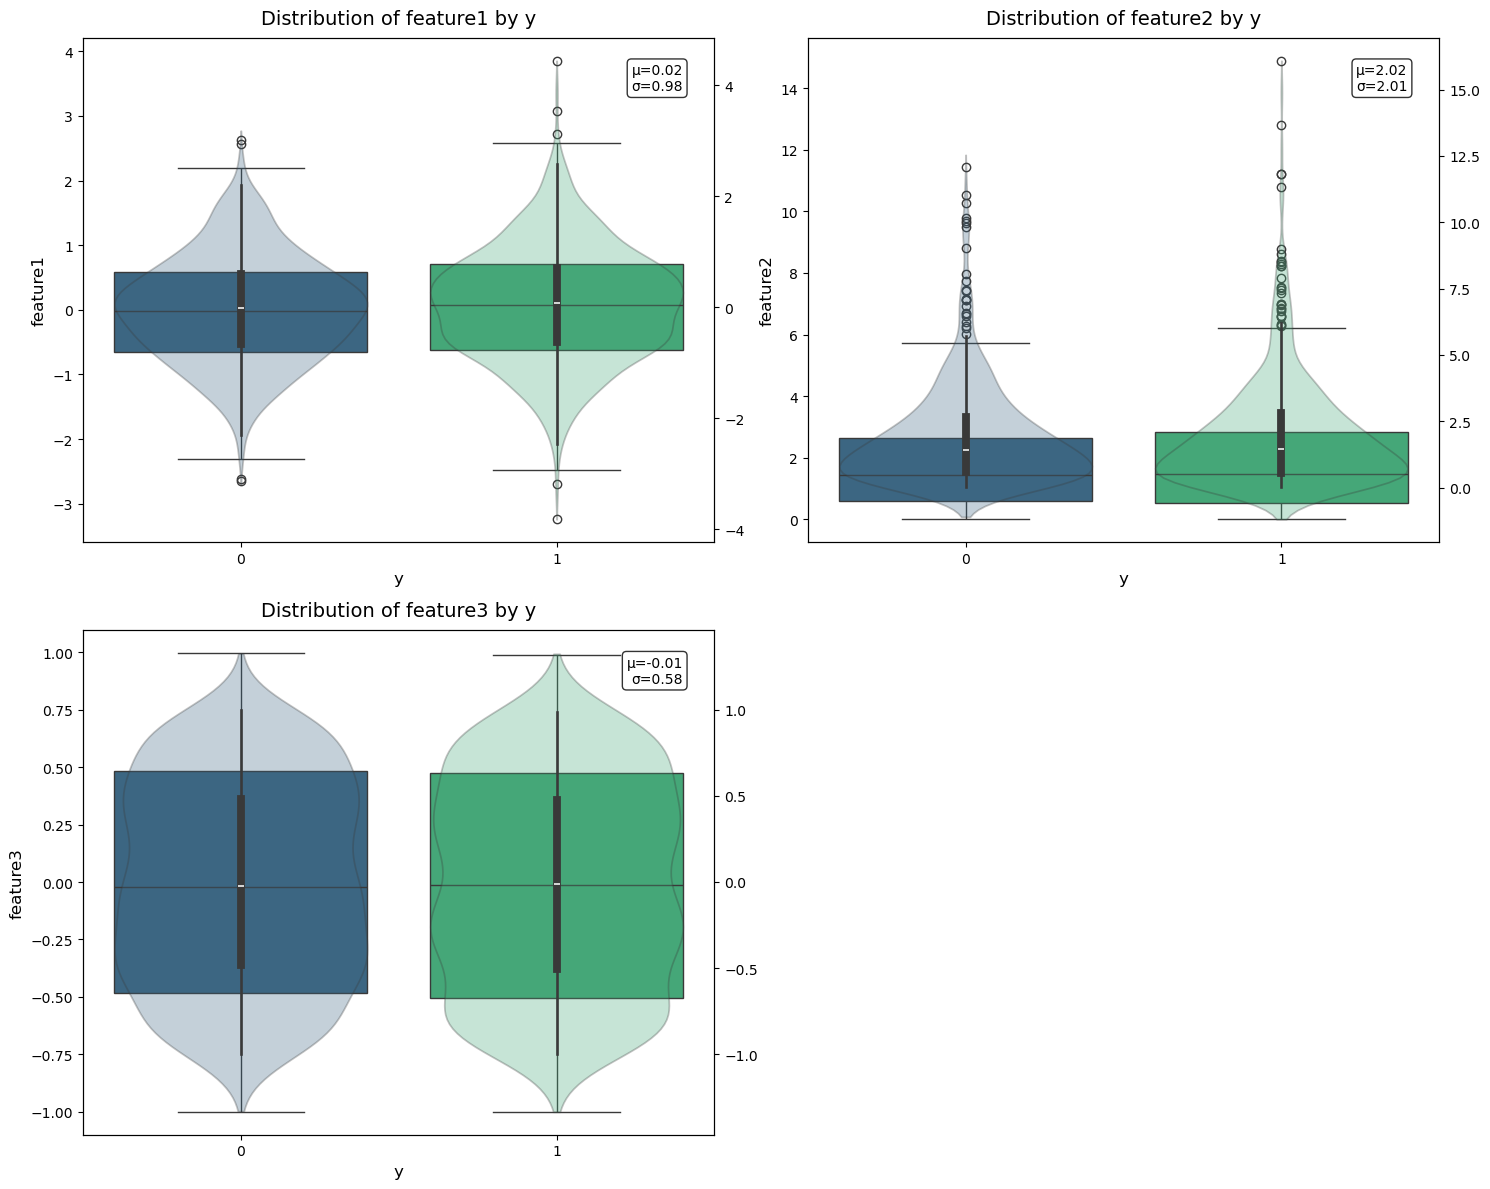

In [34]:
import logging
import warnings
from math import ceil
from typing import List, Optional, Dict, Tuple, Union

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

def plot_numeric_distributions(
    df: pd.DataFrame,
    numeric_features: List[str],
    target_col: str,
    plot_type: str = 'both',
    n_cols: int = 3,
    figsize: Tuple[int, int] = (15, 6),
    max_unique_targets: int = 10,
    palette: str = 'viridis',
    title_fontsize: int = 10,
    label_fontsize: int = 8,
    show_stats: bool = True
) -> Optional[Dict]:
    """
    Create distribution plots (box and/or violin) for numeric features grouped by target.
    
    Args:
        df: Input DataFrame
        numeric_features: List of numeric column names to plot
        target_col: Name of target column for grouping
        plot_type: Type of plot ('box', 'violin', or 'both')
        n_cols: Number of columns in the plot grid
        figsize: Base figure size (width, height)
        max_unique_targets: Maximum allowed unique target values
        palette: Color palette for plots
        title_fontsize: Font size for plot titles
        label_fontsize: Font size for axis labels
        show_stats: Whether to show statistics on plots
        
    Returns:
        Optional[Dict]: Dictionary of statistics if show_stats=True
    """
    # Set up logging with a specific name for this function
    logger = logging.getLogger(__name__ + '.plot_distributions')
    
    def validate_inputs() -> None:
        """Validate all input parameters."""
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input 'df' must be a pandas DataFrame")
            
        if not numeric_features:
            raise ValueError("numeric_features list cannot be empty")
            
        missing_cols = [col for col in numeric_features if col not in df.columns]
        if missing_cols:
            raise KeyError(f"Features not found in DataFrame: {missing_cols}")
            
        if target_col not in df.columns:
            raise KeyError(f"Target column '{target_col}' not found")
            
        n_unique = df[target_col].nunique()
        if n_unique > max_unique_targets:
            raise ValueError(
                f"Too many unique target values ({n_unique}). "
                f"Maximum allowed is {max_unique_targets}"
            )
    
    def create_figure_and_grid():
        """Create and return figure and GridSpec objects."""
        n_features = len(numeric_features)
        n_rows = ceil(n_features / n_cols)
        
        # Adjust figure height based on number of rows
        height_per_row = figsize[1] / 2
        adjusted_figsize = (figsize[0], height_per_row * n_rows)
        
        fig = plt.figure(figsize=adjusted_figsize)
        gs = GridSpec(n_rows, n_cols, figure=fig)
        
        return fig, gs, n_rows
    
    def create_distribution_plot(ax: plt.Axes, feature: str) -> Dict:
        """Create distribution plot for a single feature."""
        stats = {}
        
        # Suppress categorical warnings just for the plotting
        with warnings.catch_warnings():
            warnings.filterwarnings(
                'ignore',
                category=UserWarning,
                message='Using categorical units to plot a list of strings.*'
            )
            
            # Create box plot if requested
            if plot_type in ['box', 'both']:
                sns.boxplot(
                    x=target_col,
                    y=feature,
                    data=df,
                    hue=target_col,
                    palette=palette,
                    ax=ax,
                    legend=False
                )
            
            # Create violin plot if requested
            if plot_type in ['violin', 'both']:
                if plot_type == 'both':
                    ax2 = ax.twinx()
                    sns.violinplot(
                        x=target_col,
                        y=feature,
                        data=df,
                        hue=target_col,
                        palette=palette,
                        alpha=0.3,
                        ax=ax2,
                        legend=False
                    )
                    ax2.set_ylabel('')
                else:
                    sns.violinplot(
                        x=target_col,
                        y=feature,
                        data=df,
                        hue=target_col,
                        palette=palette,
                        ax=ax,
                        legend=False
                    )
        
        # Calculate statistics if requested
        if show_stats:
            stats = {
                'mean': df[feature].mean(),
                'std': df[feature].std(),
                'by_target': df.groupby(target_col)[feature].agg(['mean', 'std']).to_dict()
            }
            
            stat_text = f"μ={stats['mean']:.2f}\nσ={stats['std']:.2f}"
            ax.text(
                0.95, 0.95, stat_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
            )
        
        # Set titles and labels
        ax.set_title(
            f'Distribution of {feature} by {target_col}',
            fontsize=title_fontsize,
            pad=10
        )
        ax.set_xlabel(target_col, fontsize=label_fontsize)
        ax.set_ylabel(feature, fontsize=label_fontsize)
        
        return stats
    
    try:
        # Validate inputs
        validate_inputs()
        
        # Create figure and grid
        fig, gs, n_rows = create_figure_and_grid()
        
        # Initialize statistics dictionary if needed
        all_stats = {} if show_stats else None
        
        # Create plots for each feature
        for idx, feature in enumerate(numeric_features):
            row, col = divmod(idx, n_cols)
            ax = fig.add_subplot(gs[row, col])
            
            # Create distribution plot and get stats
            stats = create_distribution_plot(ax, feature)
            if show_stats:
                all_stats[feature] = stats
        
        # Remove empty subplots if any
        for idx in range(len(numeric_features), n_rows * n_cols):
            row, col = divmod(idx, n_cols)
            fig.delaxes(fig.add_subplot(gs[row, col]))
        
        # Adjust layout
        plt.tight_layout()
        
        logger.info(f"Successfully created distribution plots for {len(numeric_features)} features")
        
        return all_stats
        
    except Exception as e:
        logger.error(f"Error creating distribution plots: {str(e)}")
        raise
    
def demonstrate_usage():
    """Demonstrates usage of the plot_numeric_distributions function."""
    # Create sample data
    np.random.seed(42)
    n_samples = 1000
    
    df = pd.DataFrame({
        'feature1': np.random.normal(0, 1, n_samples),
        'feature2': np.random.exponential(2, n_samples),
        'feature3': np.random.uniform(-1, 1, n_samples),
        'y': np.random.choice([0, 1], n_samples)
    })
    
    # Example usage with all options
    stats = plot_numeric_distributions(
        df=df,
        numeric_features=['feature1', 'feature2', 'feature3'],
        target_col='y',
        figsize=(15, 12),
        n_cols=2,
        plot_type='both',
        palette='viridis',
        title_fontsize=14,
        label_fontsize=12,
        show_stats=True
    )
    
    if stats:
        print("\nFeature Statistics:")
        for feature, feat_stats in stats.items():
            print(f"\n{feature}:")
            print(f"Overall mean: {feat_stats['mean']:.2f}")
            print(f"Overall std: {feat_stats['std']:.2f}")
            print("By target class:")
            for target, values in feat_stats['by_target'].items():
                print(f"  Class {target}: {values}")

# def init_logging():
#     class SuppressMatplotlibInfo(logging.Filter):
#         def filter(self, record):
#             return (
#                 """Using categorical units to plot a list of strings that are all 
#                 parsable as floats or dates. If these strings should be plotted as numbers,
#                 cast to the appropriate data type before plotting.
#                 """ != record.getMessage()
#             )
 
#     logging.basicConfig(level=logging.INFO)
#     matplotlib_logger = logging.getLogger("matplotlib.category")
#     matplotlib_logger.addFilter(SuppressMatplotlibInfo())

import warnings

def suppress_matplotlib_warning():
    """Suppress specific matplotlib categorical plotting warning."""
    warnings.filterwarnings(
        'ignore',
        category=UserWarning,
        message='Using categorical units to plot a list of strings.*'
    )
if __name__ == "__main__":
    
    demonstrate_usage()

In [ ]:
def get_feature_groups(df: pd.DataFrame, targe)

In [35]:
import logging
from typing import List, Optional, Tuple, Dict, Union
from math import ceil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

def plot_categorical_distributions(
    df: pd.DataFrame,
    categorical_features: List[str],
    target_col: str = 'y',
    n_cols: int = 2,
    figsize: Tuple[int, int] = (15, 5),
    max_categories: int = 20,
    min_frequency: float = 0.01,
    palette: Union[str, List[str]] = 'viridis',
    title_fontsize: int = 12,
    label_fontsize: int = 10,
    legend_fontsize: int = 9,
    rotation: int = 45,
    show_percentages: bool = True,
    show_counts: bool = True,
    grid: bool = True,
    sort_categories: bool = True
) -> Dict[str, pd.DataFrame]:
    """
    Create enhanced distribution plots for categorical features with respect to target variable.
    
    Args:
        df: Input DataFrame containing features and target
        categorical_features: List of categorical feature names to plot
        target_col: Name of target column (default: 'y')
        n_cols: Number of columns in the plot grid (default: 2)
        figsize: Base figure size (width, height) per plot
        max_categories: Maximum number of categories to show per feature (default: 20)
        min_frequency: Minimum frequency threshold for category display (default: 0.01)
        palette: Color palette for the plots (default: 'viridis')
        title_fontsize: Font size for plot titles (default: 12)
        label_fontsize: Font size for axis labels (default: 10)
        legend_fontsize: Font size for legend (default: 9)
        rotation: Rotation angle for category labels (default: 45)
        show_percentages: Whether to show percentage values on bars (default: True)
        show_counts: Whether to show absolute counts in tooltips (default: True)
        grid: Whether to show grid lines (default: True)
        sort_categories: Whether to sort categories by frequency (default: True)
    
    Returns:
        Dict[str, pd.DataFrame]: Distribution statistics for each feature
        
    Raises:
        ValueError: If input validation fails
        KeyError: If features or target column not found in DataFrame
    """
    # Set up logging
    logger = logging.getLogger(__name__)
    
    def validate_inputs() -> None:
        """Validate input parameters and data."""
        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input 'df' must be a pandas DataFrame")
            
        if not categorical_features:
            raise ValueError("categorical_features list cannot be empty")
            
        missing_cols = [col for col in categorical_features if col not in df.columns]
        if missing_cols:
            raise KeyError(f"Features not found in DataFrame: {missing_cols}")
            
        if target_col not in df.columns:
            raise KeyError(f"Target column '{target_col}' not found in DataFrame")
            
        if df[target_col].nunique() < 2:
            raise ValueError(f"Target column '{target_col}' must have at least 2 unique values")
    
    def process_feature_distribution(feature: str) -> pd.DataFrame:
        """Process and return distribution data for a single feature."""
        # Calculate value counts and frequencies
        value_counts = df[feature].value_counts()
        frequencies = value_counts / len(df)
        
        # Filter categories based on frequency threshold
        significant_categories = frequencies[frequencies >= min_frequency].index
        
        # Limit number of categories if needed
        if len(significant_categories) > max_categories:
            significant_categories = significant_categories[:max_categories]
            logger.warning(
                f"Feature '{feature}' has {len(value_counts)} categories. "
                f"Showing top {max_categories} only."
            )
        
        # Create filtered dataset
        df_filtered = df[df[feature].isin(significant_categories)]
        
        # Calculate distribution
        distribution = pd.crosstab(
            df_filtered[feature], 
            df_filtered[target_col], 
            normalize='index'
        )
        
        if sort_categories:
            # Sort by most frequent category in target
            main_category = df_filtered[target_col].mode()[0]
            distribution = distribution.sort_values(by=main_category, ascending=False)
        
        return distribution
    
    def create_subplot(ax: plt.Axes, data: pd.DataFrame, feature: str) -> None:
        """Create a single subplot for a feature."""
        # Create stacked bar plot
        data.plot(
            kind='bar',
            stacked=True,
            ax=ax,
            width=0.8,
            colormap=palette if isinstance(palette, str) else None,
            color=palette if isinstance(palette, list) else None
        )
        
        # Customize plot appearance
        ax.set_title(f'Distribution of {target_col} by {feature}', 
                    fontsize=title_fontsize, pad=20)
        ax.set_xlabel(feature, fontsize=label_fontsize)
        ax.set_ylabel('Proportion', fontsize=label_fontsize)
        
        # Rotate x-axis labels
        ax.tick_params(axis='x', rotation=rotation)
        
        # Add grid if requested
        if grid:
            ax.grid(axis='y', alpha=0.3)
        
        # Customize legend
        ax.legend(
            title=target_col,
            fontsize=legend_fontsize,
            bbox_to_anchor=(1.05, 1),
            loc='upper left'
        )
        
        # Add percentage labels if requested
        if show_percentages:
            for c in ax.containers:
                ax.bar_label(c, fmt='%.1f%%', label_type='center')
    
    try:
        # Validate inputs
        validate_inputs()
        
        # Calculate layout
        n_features = len(categorical_features)
        n_rows = ceil(n_features / n_cols)
        
        # Create figure with adjusted size
        fig = plt.figure(figsize=(figsize[0] * n_cols, figsize[1] * n_rows))
        gs = GridSpec(n_rows, n_cols, figure=fig)
        
        # Store distribution data
        distributions = {}
        
        # Create plots
        for idx, feature in enumerate(categorical_features):
            # Calculate row and column position
            row, col = divmod(idx, n_cols)
            
            # Process distribution data
            distribution = process_feature_distribution(feature)
            distributions[feature] = distribution
            
            # Create subplot
            ax = fig.add_subplot(gs[row, col])
            create_subplot(ax, distribution, feature)
        
        # Adjust layout
        plt.tight_layout()
        
        logger.info(
            f"Successfully created distribution plots for {len(categorical_features)} features"
        )
        
        return distributions
        
    except Exception as e:
        logger.error(f"Error creating distribution plots: {str(e)}")
        raise

# Example usage:
# distributions = plot_categorical_distributions(
#     df=your_dataframe,
#     categorical_features=['education', 'occupation', 'marital_status'],
#     target_col='target',
#     show_percentages=True,
#     sort_categories=True
# )

In [ ]:
# Visualize Categorical features
plot = plot_categorical_distributions(data, cat_features, 
                                      palette="Set2",
                                      show_counts=True,
                                     n_cols=2)

In [ ]:
def save_processed_data(df: pd.DataFrame, save_path: Path, filename: str = "bank_marketing_processed.csv") -> None:
    """Save processed DataFrame to CSV file.
    
    Args:
        df: Processed DataFrame to save
        save_path: Path to save directory
        filename: Name of output file. Defaults to "bank_marketing_processed.csv"
        
    Raises:
        TypeError: If inputs are not of correct type
        OSError: If there's an error writing the file
    """
    # Input validation
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame")
        
    if not isinstance(save_path, Path):
        save_path = Path(save_path)
        
    try:
        # Ensure directory exists
        save_path.mkdir(parents=True, exist_ok=True)
        
        # Create full file path
        file_path = save_path.joinpath(filename)
        
        # Save data
        df.to_csv(file_path, index=False)
        print(f"Data successfully saved to: {file_path}")
        
    except PermissionError:
        raise OSError(f"Permission denied: Unable to write to {save_path}")
    except OSError as e:
        raise OSError(f"Error saving data: {str(e)}")
    except Exception as e:
        raise RuntimeError(f"Unexpected error while saving data: {str(e)}")

In [ ]:
        
# ========================================================================= #
#         Core Functionalities
# ========================================================================= #

def load_data(filepath: str) -> pd.DataFrame:
    """
    Load the bank marketing dataset and perform initial cleaning.
    
    Parameters:
        filepath (str): Path to the dataset CSV file
    
    Returns:
        pd.DataFrame: Cleaned dataset
    """
    # Read the dataset
    df = pd.read_csv(filepath, sep=';')
    
    # Convert column names to lowercase
    df.columns = df.columns.str.lower()
    
    # Strip whitespace from string columns
    object_columns = df.select_dtypes(include=['object']).columns
    df[object_columns] = df[object_columns].apply(lambda x: x.str.strip())
    
    return df

def display_basic_info(df: pd.DataFrame) -> None:
    """
    Display basic information about the dataset.
    
    Args:
        df (pd.DataFrame): Input dataset
    """
    print("="*72)
    print("Dataset Overview:")
    print("="*72)
    print("\nDataset Shape:", df.shape)
    print("\nFirst few rows:")
    print(df.head())
    
    print("\nDataset Information:")
    print("="*72)
    df.info()
    
    print("\nStatistical Summary:")
    print("="*72)
    print(df.describe())
    
    
def get_feature_groups(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    """
    Separate features into numerical and categorical groups.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        
    Returns:
        Tuple[List[str], List[str]]: Lists of numerical and categorical column names
    """
    # Identify numeric and categorical columns
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    
    # Remove target variable if present
    if 'y' in numeric_features:
        numeric_features.remove('y')
    if 'y' in categorical_features:
        categorical_features.remove('y')
    
    return numeric_features, categorical_features


def analyze_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze missing values in the dataset.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        
    Returns:
        pd.DataFrame: Missing value analysis
    """
    # Calculate missing value statistics
    missing = pd.DataFrame({
        'count': df.isnull().sum(),
        'percentage': (df.isnull().sum() / len(df) * 100).round(2)
    })
    
    return missing[missing['count'] > 0].sort_values('percentage', ascending=False)


def analyze_target_distribution(df: pd.DataFrame) -> Dict[str, float]:
    """
    Analyze the distribution of the target variable.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        
    Returns:
        Dict[str, float]: Target distribution statistics
    """
    target_dist = df['y'].value_counts(normalize=True)
    target_counts = df['y'].value_counts()
    
    # Calculate imbalance ratio with explicit float conversion and rounding
    imbalance_ratio = float(target_counts.min()) / float(target_counts.max())
    
    return {
        'distribution': {k: float(v) for k, v in target_dist.to_dict().items()},
        'counts': target_counts.to_dict(),
        'imbalance_ratio': round(imbalance_ratio, 3)
    }


def preprocess_numeric_features(df: pd.DataFrame,
                                numeric_features: List[str]) -> Tuple[pd.DataFrame, StandardScaler]:
    """
    Preprocess numerical features using StandardScaler.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        numeric_features (List[str]): List of numerical feature names
        
    Returns:
        Tuple[pd.DataFrame, StandardScaler]: Preprocessed data and fitted scaler
    """
    scaler = StandardScaler()
    df_processed = df.copy()
    
    # Scale numeric features
    df_processed[numeric_features] = scaler.fit_transform(df[numeric_features])
    
    return df_processed, scaler


def encode_categorical_features(df: pd.DataFrame,
                              categorical_features: List[str]
                             ) -> Tuple[pd.DataFrame, OneHotEncoder]:
    """
    Encode categorical features using OneHotEncoder.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        categorical_features (List[str]): List of categorical feature names
        
    Returns:
        Tuple[pd.DataFrame, OneHotEncoder]: DataFrame with one-hot encoded features 
        and the fitted encoder
    """
    df_encoded = df.copy()
    
    # Initialize OneHotEncoder with appropriate parameters
    encoder = OneHotEncoder(
        sparse_output=False,  # Return dense array instead of sparse matrix
        handle_unknown='ignore',  # Handle new categories in test data
        drop='if_binary'  # Drop one category for binary features to avoid multicollinearity
    )
    
    # Fit and transform the categorical features
    encoded_features = encoder.fit_transform(df[categorical_features])
    
    # Get feature names after encoding
    feature_names = encoder.get_feature_names_out(categorical_features)
    
    # Create a DataFrame with encoded features
    encoded_df = pd.DataFrame(
        encoded_features,
        columns=feature_names,
        index=df.index
    )
    
    # Drop original categorical columns
    df_encoded = df_encoded.drop(columns=categorical_features)
    
    # Concatenate encoded features with original numeric features
    df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
    
    return df_encoded, encoder


def encode_target(df: pd.DataFrame, target_column: str) -> Tuple[pd.DataFrame, LabelEncoder]:
    """
    Encode the target variable using LabelEncoder.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        target_column (str): Name of the target column
        
    Returns:
        Tuple[pd.DataFrame, LabelEncoder]: DataFrame with encoded target and the fitted encoder
    """
    df_encoded = df.copy()
    encoder = LabelEncoder()
    
    # Fit and transform the target variable
    df_encoded[target_column] = encoder.fit_transform(df[target_column])
    
    return df_encoded, encoder


def plot_numeric_distributions(df: pd.DataFrame, 
                               numeric_features: List[str],
                               target_col: str = 'y') -> None:
    """
    Plot distributions of numeric features with respect to target variable.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        numeric_features (List[str]): List of numerical feature names
        target_col (str): Name of target column
    """
    n_features = len(numeric_features)
    n_cols = 2
    n_rows = (n_features + 1) // 2
    
    plt.figure(figsize=(15, 5 * n_rows))
    
    for i, feature in enumerate(numeric_features, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(x=target_col, y=feature, data=df)
        plt.title(f'Distribution of {feature} by {target_col}')
        
    plt.tight_layout()
    plt.show()

    
def plot_categorical_distributions(df: pd.DataFrame, 
                                   categorical_features: List[str],
                                   target_col: str = 'y') -> None:
    """
    Plot distributions of categorical features with respect to target variable.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        categorical_features (List[str]): List of categorical feature names
        target_col (str): Name of target column
    """
    n_features = len(categorical_features)
    n_cols = 2
    n_rows = (n_features + 1) // 2
    
    plt.figure(figsize=(15, 5 * n_rows))
    
    for i, feature in enumerate(categorical_features, 1):
        plt.subplot(n_rows, n_cols, i)
        df_grouped = df.groupby(feature)[target_col].value_counts(normalize=True).unstack()
        df_grouped.plot(kind='bar', stacked=True)
        plt.title(f'Distribution of {target_col} by {feature}')
        plt.legend(title=target_col)
        plt.xticks(rotation=45)
        
    plt.tight_layout()
    plt.show()
    

def prepare_data_for_modeling(df: pd.DataFrame, target_col: str = 'y', 
                              test_size: float = 0.2, random_state: int = 42) -> Tuple:
    """
    Prepare data for modeling by splitting into train and test sets.
    
    Parameters:
        df (pd.DataFrame): Preprocessed dataset
        target_col (str): Name of target column
        test_size (float): Proportion of data to use for testing
        random_state (int): Random seed for reproducibility
        
    Returns:
        Tuple: (X_train, X_test, y_train, y_test)
    """
    # Prepare features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Encode target if it's categorical
    if y.dtype == 'object':
        y = LabelEncoder().fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    return X_train, X_test, y_train, y_test


def generate_data_summary(df: pd.DataFrame) -> Dict:
    """
    Generate a comprehensive summary of the dataset.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        
    Returns:
        Dict: Summary statistics and information
    """
    numeric_features, categorical_features = get_feature_groups(df)
    
    summary = {
        'dataset_shape': df.shape,
        'numeric_features': {
            'count': len(numeric_features),
            'names': numeric_features,
            'statistics': df[numeric_features].describe().to_dict()
        },
        'categorical_features': {
            'count': len(categorical_features),
            'names': categorical_features,
            'unique_values': {col: df[col].nunique() for col in categorical_features}
        },
        'target_distribution': analyze_target_distribution(df),
        'missing_values': analyze_missing_values(df).to_dict()
    }
    
    return summary

def encode_target(df: pd.DataFrame, target_column: str) -> Tuple[pd.DataFrame, LabelEncoder]:
    """
    Encode the target variable using LabelEncoder.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        target_column (str): Name of the target column
        
    Returns:
        Tuple[pd.DataFrame, LabelEncoder]: DataFrame with encoded target and the fitted encoder
    """
    df_encoded = df.copy()
    print(df_encoded.head(3))
    encoder = LabelEncoder()
    
    # Fit and transform the target variable
    df_encoded[target_column] = encoder.fit_transform(df[target_column])
    
    return df_encoded, encoder


def preprocess_data(df: pd.DataFrame,
                    categorical_features: List[str],
                    numeric_features: List[str],
                    target_column: str) -> Tuple[pd.DataFrame, OneHotEncoder, StandardScaler, LabelEncoder]:
    """
    Preprocess the data by applying transformations in the correct order:
    1. Encode categorical features
    2. Scale numeric features
    3. Encode target variable
    
    Parameters:
        df (pd.DataFrame): Input dataset
        categorical_features (List[str]): List of categorical feature names
        numeric_features (List[str]): List of numerical feature names
        target_column (str): Name of the target column
        
    Returns:
        Tuple containing:
        - Preprocessed DataFrame
        - Fitted OneHotEncoder
        - Fitted StandardScaler
        - Fitted LabelEncoder
    """
    # 1. First encode categorical features
    df_processed, cat_encoder = encode_categorical_features(df, categorical_features)
    
    # 2. Then scale numeric features
    df_processed, num_scaler = preprocess_numeric_features(df_processed, numeric_features)
    
    # 3. Finally encode the target
    df_processed, target_encoder = encode_target(df_processed, target_column)
    
    return df_processed, cat_encoder, num_scaler, target_encoder


from sklearn.utils.class_weight import compute_class_weight

def compute_balanced_weights(y):
    """
    Compute balanced class weights for imbalanced target variable.
    
    Parameters:
        y: Target variable (encoded)
    Returns:
        dict: Dictionary with class weights
    """
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y),
        y=y
    )
    return dict(zip(np.unique(y), class_weights))

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def handle_imbalanced_data(df: pd.DataFrame, 
                          target_column: str,
                          strategy: str = 'smote') -> pd.DataFrame:
    """
    Handle imbalanced dataset using various techniques.
    
    Parameters:
        df (pd.DataFrame): Preprocessed dataframe
        target_column (str): Name of target column
        strategy (str): Resampling strategy ('smote', 'undersample', or 'combine')
        
    Returns:
        pd.DataFrame: Resampled dataframe
    """
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    if strategy == 'smote':
        # Use SMOTE to oversample minority class
        sampler = SMOTE(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X, y)
    
    elif strategy == 'undersample':
        # Undersample majority class
        sampler = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X, y)
    
    elif strategy == 'combine':
        # Combine SMOTE with undersampling
        over = SMOTE(sampling_strategy=0.5, random_state=42)  # Oversample to 50% ratio
        under = RandomUnderSampler(sampling_strategy=0.75, random_state=42)  # Further balance
        pipeline = Pipeline([('over', over), ('under', under)])
        X_resampled, y_resampled = pipeline.fit_resample(X, y)
    
    # Reconstruct dataframe
    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled[target_column] = y_resampled
    
    return df_resampled


def preprocess_data(df: pd.DataFrame,
                    categorical_features: List[str],
                    numeric_features: List[str],
                    target_column: str,
                    handle_imbalance: str = None
                   ) -> Tuple[pd.DataFrame, OneHotEncoder, StandardScaler, LabelEncoder]:
    """
    Enhanced preprocessing pipeline that handles class imbalance.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        categorical_features (List[str]): List of categorical feature names
        numeric_features (List[str]): List of numerical feature names
        target_column (str): Name of the target column
        handle_imbalance (str): Strategy for handling imbalance ('smote', 'undersample', 'combine', or None)
        
    Returns:
        Tuple containing:
        - Preprocessed DataFrame
        - Fitted OneHotEncoder
        - Fitted StandardScaler
        - Fitted LabelEncoder
    """
    # 1. First encode categorical features
    df_processed, cat_encoder = encode_categorical_features(df, categorical_features)
    
    # 2. Then scale numeric features
    df_processed, num_scaler = preprocess_numeric_features(df_processed, numeric_features)
    
    # 3. Encode the target
    df_processed, target_encoder = encode_target(df_processed, target_column)
    
    # 4. Handle class imbalance if specified
    if handle_imbalance:
        df_processed = handle_imbalanced_data(df_processed, target_column, handle_imbalance)
    
    return df_processed, cat_encoder, num_scaler, target_encoder

# Bank Marketing Prediction Project

## Project Overview
This project focuses on predicting whether a client will subscribe to a bank term deposit using machine learning techniques. We'll implement a deep learning solution using Python and the Keras API.

## Dataset Description

The dataset comes from a **Portuguese banking institution's direct marketing campaigns**. The marketing campaigns were based on phone calls, often requiring multiple contacts with the same client.

### Features Description

#### Bank Client Data
| Feature    | Type        | Description                                     |
|------------|-------------|-------------------------------------------------|
| age        | numeric     | Client's age                                    |
| job        | categorical | Type of job (admin, technician, etc.)           |
| marital    | categorical | Marital status                                  |
| education  | categorical | Education level                                 |
| default    | categorical | Has credit in default?                          |
| balance    | numeric     | Average yearly balance in euros                 |
| housing    | categorical | Has housing loan?                               |
| loan       | categorical | Has personal loan?                              |

#### Campaign Data

| Feature    | Type        | Description                                     |
|------------|-------------|-------------------------------------------------|
| contact    | categorical | Contact communication type                      |
| day        | numeric     | Last contact day of the month                   |
| month      | categorical | Last contact month of year                      |
| duration   | numeric     | Last contact duration in seconds                |
| campaign   | numeric     | Number of contacts for this campaign            |
| pdays      | numeric     | Days since last contact from previous campaign  |
| previous   | numeric     | Number of contacts before this campaign         |
| poutcome   | categorical | Outcome of the previous campaign                |

#### Target Variable
- **y (binary)**: Has the client subscribed to a term deposit? (yes/no)

## Project Steps

### 1. Data Preprocessing
- Load and inspect the dataset
- Handle missing values
- Encode categorical variables
- Scale numerical features
- Split data into training and testing sets

### 2. Exploratory Data Analysis (EDA)
- Statistical summary of features
- Distribution analysis
- Correlation analysis
- Feature importance analysis
- Target variable distribution

### 3. Model Development
- Design neural network architecture
- Implementation using Keras API
- Model configuration and compilation
- Training and validation

### 4. Model Evaluation
- Performance metrics analysis
  - Accuracy
  - Precision
  - Recall
  - F1-Score
  - ROC-AUC
- Confusion matrix
- Learning curves analysis

### 5. Model Optimization
- Hyperparameter tuning
- Cross-validation
- Model architecture optimization
- Handling class imbalance

### 6. Model Deployment
- Save and load model
- Create prediction pipeline
- Model serving considerations

## Technical Requirements
- Python 3.8+
- Key Libraries:
  - TensorFlow/Keras
  - NumPy
  - Pandas
  - Scikit-learn
  - Matplotlib
  - Seaborn

# =============================================================================
# Deep Learning Model Development Roadmap: Bank Marketing Prediction
# =============================================================================

### 1. Data Preparation Phase
   - Load Bank Marketing Dataset
   - Initial data inspection and summary statistics
   - Check for missing values and data consistency
   - Identify feature types:
     * Numerical Features: age, balance, day, duration, campaign, pdays, previous
     * Categorical Features: job, marital, education, default, housing, loan, contact, month, poutcome
   - Target variable analysis (y - subscription status)

### 2. Exploratory Data Analysis (EDA)
   - Distribution analysis of target variable (subscription rates)
   - Feature-target relationships:
     * Age vs subscription probability
     * Balance vs subscription probability
     * Campaign contact patterns
   - Categorical feature analysis:
     * Education level impact
     * Job type distribution
     * Marital status influence
   - Campaign-specific analysis:
     * Previous campaign success rates
     * Contact timing patterns
     * Duration vs success rate
   - Correlation analysis and feature relationships

### 3. Data Preprocessing
   - Numerical Features
     * Feature scaling (StandardScaler)
     * Handle outliers in balance and duration
     * Transform skewed distributions
     * Handle 'pdays' special values (-1 for no previous contact)
   - Categorical Features
     * One-hot encoding vs Label encoding
     * Handle high cardinality in 'job' category
     * Create dummy variables for categorical features
   - Feature Engineering
     * Create interaction terms
     * Derive new features from campaign data
     * Time-based feature engineering (day, month)

### 4. Data Splitting and Balance
   - Handle class imbalance:
     * Analyze subscription ratio
     * Consider SMOTE or class weights
   - Train-Validation-Test split
     * Stratified splitting
     * Maintain temporal order (if relevant)
   - Data validation checks

### 5. Model Development
   - Neural Network Architecture Design
     * Input layer configuration for mixed features
     * Hidden layer design
     * Binary classification output layer
   - Model Configuration
     * Activation functions selection
     * Loss function (binary crossentropy)
     * Optimizer selection and configuration
   - Implementation considerations:
     * Class weight handling
     * Batch size selection
     * Learning rate strategy

### 6. Training and Monitoring
   - Training Setup
     * BatchSize and epochs configuration
     * Learning rate schedule
     * Validation monitoring
   - Callback Implementation
     * Early stopping
     * Model checkpointing
     * Learning rate reduction
   - Training Monitoring
     * Loss and accuracy tracking
     * Class prediction balance
     * Validation performance

### 7. Model Evaluation
   - Classification Metrics
     * Accuracy, Precision, Recall
     * F1-Score
     * ROC-AUC curve
   - Business Metric Analysis
     * Cost-benefit analysis
     * Campaign efficiency metrics
   - Model Behavior Analysis
     * Feature importance assessment
     * Prediction confidence analysis
     * Error case analysis

### 8. Model Optimization
   - Hyperparameter Tuning
     * Network architecture optimization
     * Learning rate fine-tuning
     * Regularization adjustment
   - Performance Improvement
     * Feature selection refinement
     * Ensemble methods consideration
     * Cross-validation implementation
   - Model Robustness
     * Sensitivity analysis
     * Threshold optimization
     * Model stability assessment

# =============================================================================
# Deep Learning Model Development Roadmap: Bank Marketing Prediction
# =============================================================================

### 1. Data Preparation Phase
   - Load Bank Marketing Dataset
   - Initial data inspection and summary statistics
   - Check for missing values and data consistency
   - Identify feature types:
     * Numerical Features: age, balance, day, duration, campaign, pdays, previous
     * Categorical Features: job, marital, education, default, housing, loan, contact, month, poutcome
   - Target variable analysis (y - subscription status)

### 2. Exploratory Data Analysis (EDA)
   - Distribution analysis of target variable (subscription rates)
   - Feature-target relationships:
     * Age vs subscription probability
     * Balance vs subscription probability
     * Campaign contact patterns
   - Categorical feature analysis:
     * Education level impact
     * Job type distribution
     * Marital status influence
   - Campaign-specific analysis:
     * Previous campaign success rates
     * Contact timing patterns
     * Duration vs success rate
   - Correlation analysis and feature relationships

### 3. Data Preprocessing
   - Numerical Features
     * Feature scaling (StandardScaler)
     * Handle outliers in balance and duration
     * Transform skewed distributions
     * Handle 'pdays' special values (-1 for no previous contact)
   - Categorical Features
     * One-hot encoding vs Label encoding
     * Handle high cardinality in 'job' category
     * Create dummy variables for categorical features
   - Feature Engineering
     * Create interaction terms
     * Derive new features from campaign data
     * Time-based feature engineering (day, month)

### 4. Data Splitting and Balance
   - Handle class imbalance:
     * Analyze subscription ratio
     * Consider SMOTE or class weights
   - Train-Validation-Test split
     * Stratified splitting
     * Maintain temporal order (if relevant)
   - Data validation checks

In [102]:
# ========================================================================= #
#       Bank Marketing Project
# ========================================================================= #

# 1. Download the dataset
def download_bank_dataset(save_path='data'):
    """
    Download the Bank Marketing dataset from UCI repository
    
    Parameters:
        save_path (str): Directory to save the dataset
    """
    # Create directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # URL of the dataset
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"

    print("Downloading dataset...")
    response = requests.get(url)
    
    if response.status_code == 200:
        # Extract the zip file
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            zip_ref.extractall(save_path)
            
        print(f"Dataset downloaded and extracted to {save_path}")
    else:
        print("Failed to download dataset")

        
def remove_macosx_artifacts(data_path: str) -> None:
    """
    Remove macOS-specific '__MACOSX' directory if it exists.
    
    Args:
        data_path (str): Path to the parent directory containing potential macOS artifacts
        
    Raises:
        OSError: If there's an error during directory removal
        TypeError: If data_path is not a string
    """
    try:
        macosx_dir = os.path.join(data_path, '__MACOSX')
        if os.path.exists(macosx_dir) and os.path.isdir(macosx_dir):
            shutil.rmtree(macosx_dir)
            print(f"Successfully removed macOS artifact directory: {macosx_dir}")
    except OSError as e:
        logger.error(f"Failed to remove macOS artifact directory: {str(e)}")
        raise
        
        
def remove_hidden_files(directory: str) -> None:
    """
    Remove all hidden files (files starting with '.') from the specified directory.
    
    Args:
        directory (str): Path to the directory to clean
        
    Raises:
        OSError: If there's an error accessing or removing files
    """
    # logger = logging.getLogger('system_cleaner')
    
    try:
        # Get the full path to the bank-additional directory
        target_dir = os.path.join(data_path, 'bank-additional')
        
        # Iterate through files
        for filename in os.listdir(target_dir):
            if filename.startswith('.'):
                file_path = os.path.join(target_dir, filename)
                if os.path.isfile(file_path):
                    os.remove(file_path)
                    print(f"Removed hidden file: {filename}")
                    
    except OSError as e:
        print(f"Failed to remove hidden files: {str(e)}")
        raise
    except Exception as e:
        print(f"Unexpected error occurred: {str(e)}")
        raise        
        
# ========================================================================= #
#         Core Functionalities
# ========================================================================= #

def load_data(filepath: str) -> pd.DataFrame:
    """
    Load the bank marketing dataset and perform initial cleaning.
    
    Parameters:
        filepath (str): Path to the dataset CSV file
    
    Returns:
        pd.DataFrame: Cleaned dataset
    """
    # Read the dataset
    df = pd.read_csv(filepath, sep=';')
    
    # Convert column names to lowercase
    df.columns = df.columns.str.lower()
    
    # Strip whitespace from string columns
    object_columns = df.select_dtypes(include=['object']).columns
    df[object_columns] = df[object_columns].apply(lambda x: x.str.strip())
    
    return df

def display_basic_info(df: pd.DataFrame) -> None:
    """
    Display basic information about the dataset.
    
    Args:
        df (pd.DataFrame): Input dataset
    """
    print("="*72)
    print("Dataset Overview:")
    print("="*72)
    print("\nDataset Shape:", df.shape)
    print("\nFirst few rows:")
    print(df.head())
    
    print("\nDataset Information:")
    print("="*72)
    df.info()
    
    print("\nStatistical Summary:")
    print("="*72)
    print(df.describe())
    
    
def get_feature_groups(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    """
    Separate features into numerical and categorical groups.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        
    Returns:
        Tuple[List[str], List[str]]: Lists of numerical and categorical column names
    """
    # Identify numeric and categorical columns
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()
    
    # Remove target variable if present
    if 'y' in numeric_features:
        numeric_features.remove('y')
    if 'y' in categorical_features:
        categorical_features.remove('y')
    
    return numeric_features, categorical_features


def analyze_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze missing values in the dataset.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        
    Returns:
        pd.DataFrame: Missing value analysis
    """
    # Calculate missing value statistics
    missing = pd.DataFrame({
        'count': df.isnull().sum(),
        'percentage': (df.isnull().sum() / len(df) * 100).round(2)
    })
    
    return missing[missing['count'] > 0].sort_values('percentage', ascending=False)


def analyze_target_distribution(df: pd.DataFrame) -> Dict[str, float]:
    """
    Analyze the distribution of the target variable.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        
    Returns:
        Dict[str, float]: Target distribution statistics
    """
    target_dist = df['y'].value_counts(normalize=True)
    target_counts = df['y'].value_counts()
    
    # Calculate imbalance ratio with explicit float conversion and rounding
    imbalance_ratio = float(target_counts.min()) / float(target_counts.max())
    
    return {
        'distribution': {k: float(v) for k, v in target_dist.to_dict().items()},
        'counts': target_counts.to_dict(),
        'imbalance_ratio': round(imbalance_ratio, 3)
    }


def preprocess_numeric_features(df: pd.DataFrame,
                                numeric_features: List[str]) -> Tuple[pd.DataFrame, StandardScaler]:
    """
    Preprocess numerical features using StandardScaler.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        numeric_features (List[str]): List of numerical feature names
        
    Returns:
        Tuple[pd.DataFrame, StandardScaler]: Preprocessed data and fitted scaler
    """
    scaler = StandardScaler()
    df_processed = df.copy()
    
    # Scale numeric features
    df_processed[numeric_features] = scaler.fit_transform(df[numeric_features])
    
    return df_processed, scaler


def encode_categorical_features(df: pd.DataFrame,
                              categorical_features: List[str]
                             ) -> Tuple[pd.DataFrame, OneHotEncoder]:
    """
    Encode categorical features using OneHotEncoder.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        categorical_features (List[str]): List of categorical feature names
        
    Returns:
        Tuple[pd.DataFrame, OneHotEncoder]: DataFrame with one-hot encoded features 
        and the fitted encoder
    """
    df_encoded = df.copy()
    
    # Initialize OneHotEncoder with appropriate parameters
    encoder = OneHotEncoder(
        sparse_output=False,  # Return dense array instead of sparse matrix
        handle_unknown='ignore',  # Handle new categories in test data
        drop='if_binary'  # Drop one category for binary features to avoid multicollinearity
    )
    
    # Fit and transform the categorical features
    encoded_features = encoder.fit_transform(df[categorical_features])
    
    # Get feature names after encoding
    feature_names = encoder.get_feature_names_out(categorical_features)
    
    # Create a DataFrame with encoded features
    encoded_df = pd.DataFrame(
        encoded_features,
        columns=feature_names,
        index=df.index
    )
    
    # Drop original categorical columns
    df_encoded = df_encoded.drop(columns=categorical_features)
    
    # Concatenate encoded features with original numeric features
    df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
    
    return df_encoded, encoder


def encode_target(df: pd.DataFrame, target_column: str) -> Tuple[pd.DataFrame, LabelEncoder]:
    """
    Encode the target variable using LabelEncoder.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        target_column (str): Name of the target column
        
    Returns:
        Tuple[pd.DataFrame, LabelEncoder]: DataFrame with encoded target and the fitted encoder
    """
    df_encoded = df.copy()
    encoder = LabelEncoder()
    
    # Fit and transform the target variable
    df_encoded[target_column] = encoder.fit_transform(df[target_column])
    
    return df_encoded, encoder


def plot_numeric_distributions(df: pd.DataFrame, 
                               numeric_features: List[str],
                               target_col: str = 'y') -> None:
    """
    Plot distributions of numeric features with respect to target variable.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        numeric_features (List[str]): List of numerical feature names
        target_col (str): Name of target column
    """
    n_features = len(numeric_features)
    n_cols = 2
    n_rows = (n_features + 1) // 2
    
    plt.figure(figsize=(15, 5 * n_rows))
    
    for i, feature in enumerate(numeric_features, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(x=target_col, y=feature, data=df)
        plt.title(f'Distribution of {feature} by {target_col}')
        
    plt.tight_layout()
    plt.show()

    
def plot_categorical_distributions(df: pd.DataFrame, 
                                   categorical_features: List[str],
                                   target_col: str = 'y') -> None:
    """
    Plot distributions of categorical features with respect to target variable.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        categorical_features (List[str]): List of categorical feature names
        target_col (str): Name of target column
    """
    n_features = len(categorical_features)
    n_cols = 2
    n_rows = (n_features + 1) // 2
    
    plt.figure(figsize=(15, 5 * n_rows))
    
    for i, feature in enumerate(categorical_features, 1):
        plt.subplot(n_rows, n_cols, i)
        df_grouped = df.groupby(feature)[target_col].value_counts(normalize=True).unstack()
        df_grouped.plot(kind='bar', stacked=True)
        plt.title(f'Distribution of {target_col} by {feature}')
        plt.legend(title=target_col)
        plt.xticks(rotation=45)
        
    plt.tight_layout()
    plt.show()
    

def prepare_data_for_modeling(df: pd.DataFrame, target_col: str = 'y', 
                              test_size: float = 0.2, random_state: int = 42) -> Tuple:
    """
    Prepare data for modeling by splitting into train and test sets.
    
    Parameters:
        df (pd.DataFrame): Preprocessed dataset
        target_col (str): Name of target column
        test_size (float): Proportion of data to use for testing
        random_state (int): Random seed for reproducibility
        
    Returns:
        Tuple: (X_train, X_test, y_train, y_test)
    """
    # Prepare features and target
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Encode target if it's categorical
    if y.dtype == 'object':
        y = LabelEncoder().fit_transform(y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    return X_train, X_test, y_train, y_test


def generate_data_summary(df: pd.DataFrame) -> Dict:
    """
    Generate a comprehensive summary of the dataset.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        
    Returns:
        Dict: Summary statistics and information
    """
    numeric_features, categorical_features = get_feature_groups(df)
    
    summary = {
        'dataset_shape': df.shape,
        'numeric_features': {
            'count': len(numeric_features),
            'names': numeric_features,
            'statistics': df[numeric_features].describe().to_dict()
        },
        'categorical_features': {
            'count': len(categorical_features),
            'names': categorical_features,
            'unique_values': {col: df[col].nunique() for col in categorical_features}
        },
        'target_distribution': analyze_target_distribution(df),
        'missing_values': analyze_missing_values(df).to_dict()
    }
    
    return summary

In [3]:
# The directory where the data will be saved
data_path = "../../datasets/classification/bank_marketing" # change this path based on your requirements

# Download the dataset
download_bank_dataset(save_path = data_path)

Dataset downloaded and extracted to ../../datasets/classification/bank_marketing


In [11]:
# List the content of data directory
os.listdir(data_path)

['bank-additional']

In [10]:
# Remove `'__MACOSX' directory
remove_macosx_artifacts(data_path)

Successfully removed macOS artifact directory: ../../datasets/classification/bank_marketing/__MACOSX


In [15]:
# List the dir now
print(os.listdir(os.path.join(data_path, 'bank-additional')))

['.Rhistory', '.DS_Store', 'bank-additional-names.txt', 'bank-additional.csv', 'bank-additional-full.csv']


In [32]:
target_dir = os.path.join(data_path, 'bank-additional')
        
# Iterate through files
for filename in os.listdir(target_dir):
    if filename.startswith('.') and os.path.isfile(os.path.join(target_dir, filename)):
        print(filename)

.Rhistory
.DS_Store


In [33]:
# Clean the directory
remove_hidden_files(data_path)

Removed hidden file: .Rhistory
Removed hidden file: .DS_Store


In [34]:
os.listdir(target_dir)

['bank-additional-names.txt',
 'bank-additional.csv',
 'bank-additional-full.csv']

In [35]:
data_dir = os.path.join(data_path, 'bank-additional/bank-additional-full.csv')

In [37]:
# 2. Loading the dataset
data = load_data(data_dir)

In [39]:
# 3. Explore the data
display_basic_info(data)

Dataset Overview:

Dataset Shape: (41188, 21)

First few rows:
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1

In [44]:
# Get numeric and categorical features
num_features, cat_features = get_feature_groups(data)
print(num_features)
print(cat_features)

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [49]:
# assert that the number of numeric features plus categorical features
# is equal the total number of data features
assert len(num_features) + len(cat_features) == len(data.columns.to_list()) -1 

In [53]:
# Analyze the missing data
if len(analyze_missing_values(data))>0:
    print(analyze_missing_values(data))
else:
    print("No missing points found...")

No missing points found


In [82]:
# Analyze the target variable
from pprint import pprint
pprint(analyze_target_distribution(data))

{'distribution': {'no': 0.8873458288821987, 'yes': 0.11265417111780131},
 'counts': {'no': 36548, 'yes': 4640},
 'imbalance_ratio': 0.127}

In [105]:
# Process Numeric Features
df_num_processed, _ = preprocess_numeric_features(data, num_features)

In [106]:
df_num_processed

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,1.533034,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,-0.565922,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.712460,0.331680,no
1,1.628993,services,married,high.school,unknown,no,no,telephone,may,mon,...,-0.565922,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.712460,0.331680,no
2,-0.290186,services,married,high.school,no,yes,no,telephone,may,mon,...,-0.565922,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.712460,0.331680,no
3,-0.002309,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,-0.565922,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.712460,0.331680,no
4,1.533034,services,married,high.school,no,no,yes,telephone,may,mon,...,-0.565922,0.195414,-0.349494,nonexistent,0.648092,0.722722,0.886447,0.712460,0.331680,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,3.164336,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,-0.565922,0.195414,-0.349494,nonexistent,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,yes
41184,0.573445,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,-0.565922,0.195414,-0.349494,nonexistent,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,no
41185,1.533034,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,-0.204909,0.195414,-0.349494,nonexistent,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,no
41186,0.381527,technician,married,professional.course,no,no,no,cellular,nov,fri,...,-0.565922,0.195414,-0.349494,nonexistent,-0.752343,2.058168,-2.224953,-1.495186,-2.815697,yes


In [110]:
# preprocess categorical features
df_processed, _ = encode_categorical_features(data, cat_features)

In [108]:
# Encode the target variable
df_processed, _ = encode_target(data, 'y')

In [111]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  int64  
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  int64  
 4   previous                       41188 non-null  int64  
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  y                              41188 non-null  object 
 11  job_admin.                     41188 non-null  float64
 12  job_blue-collar                41188 non-null 

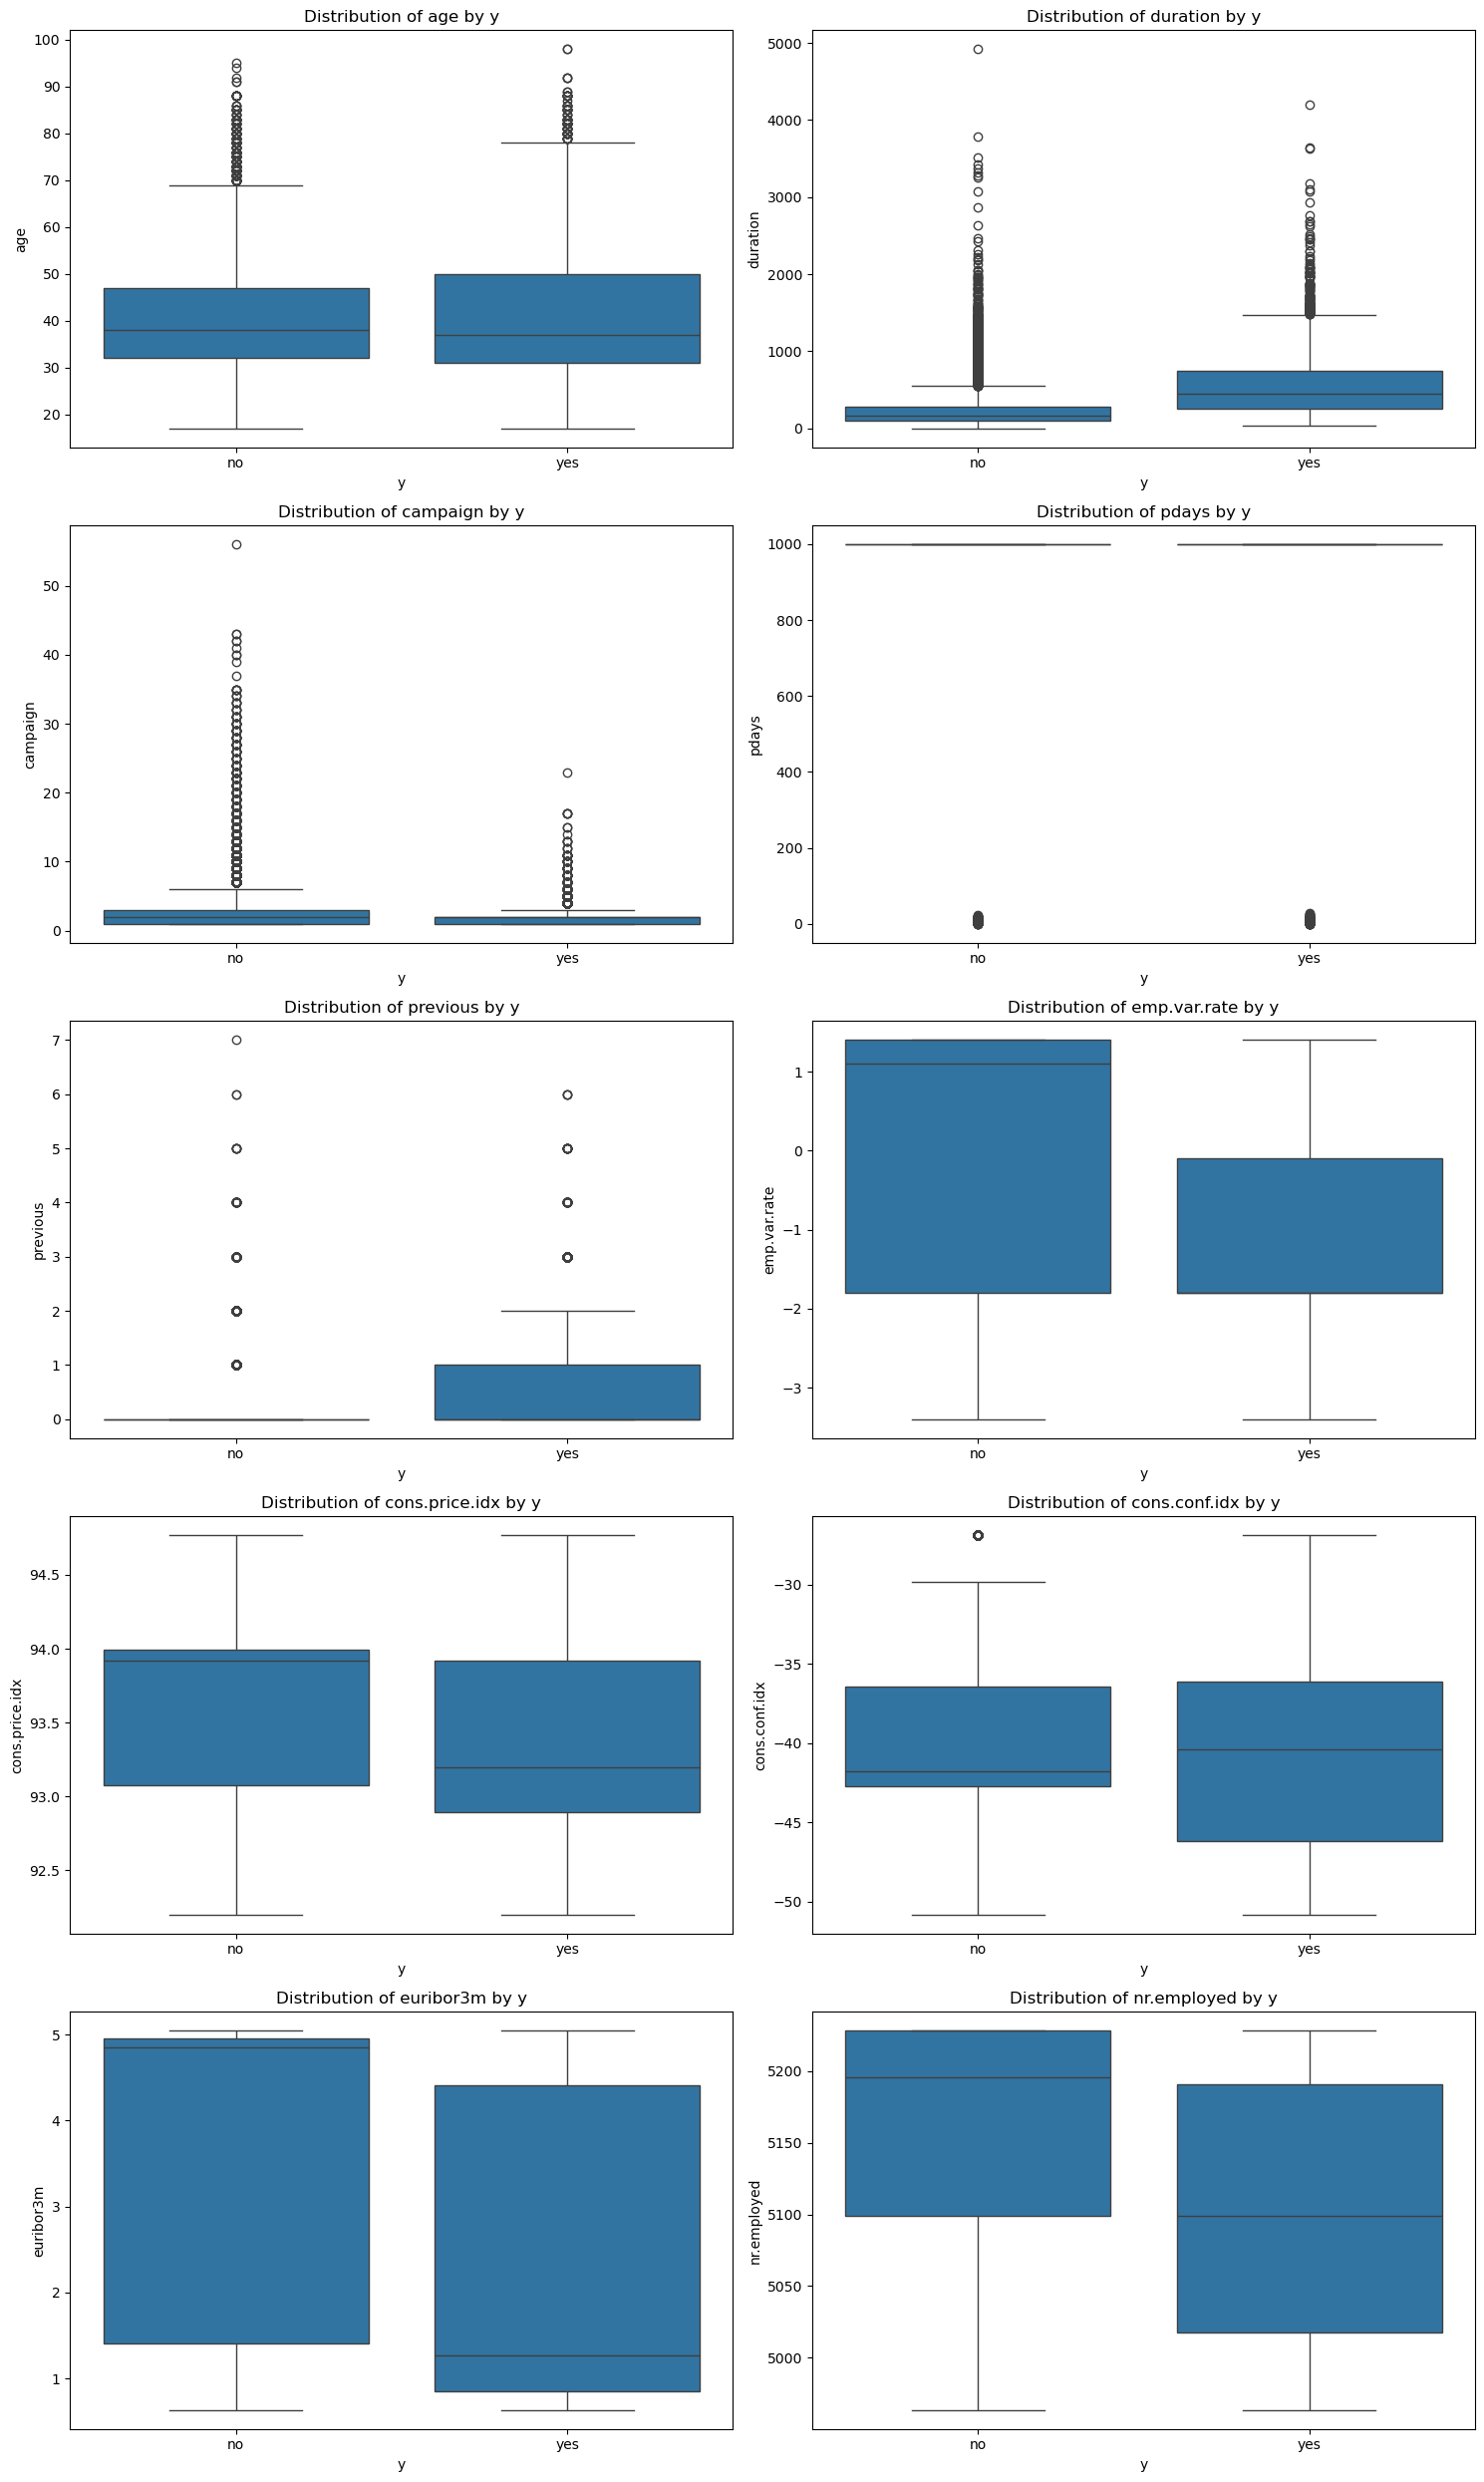

In [90]:
plot_numeric_distributions(data, num_features)

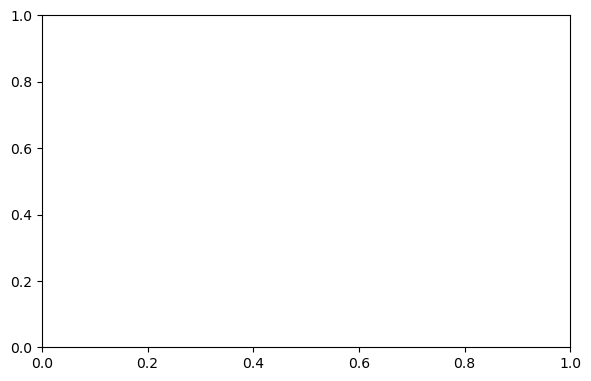

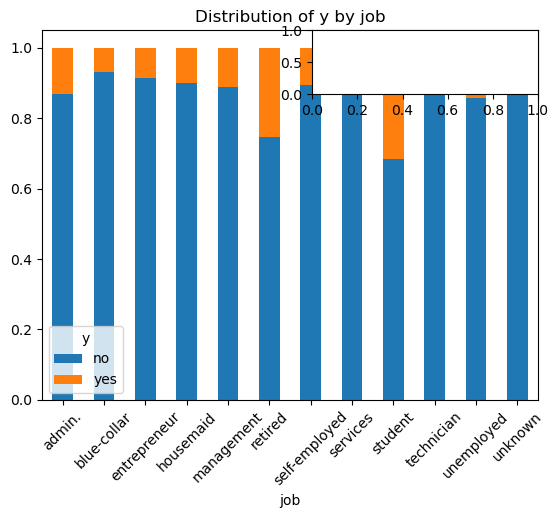

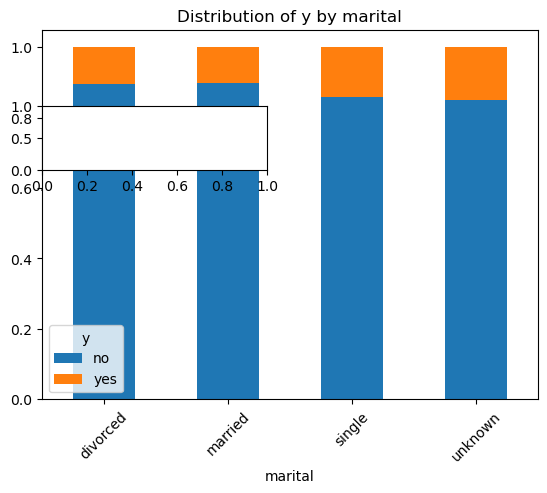

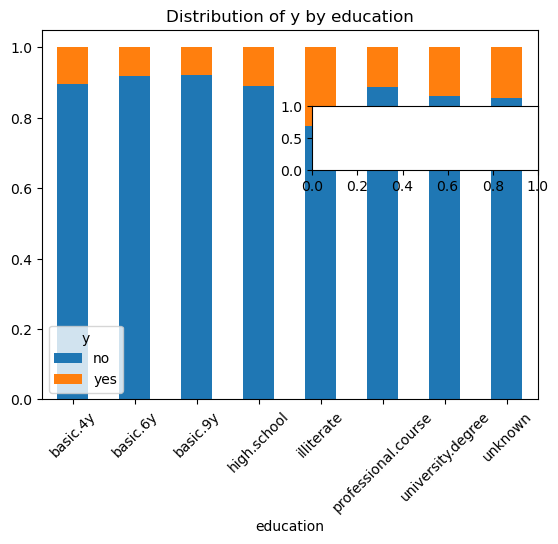

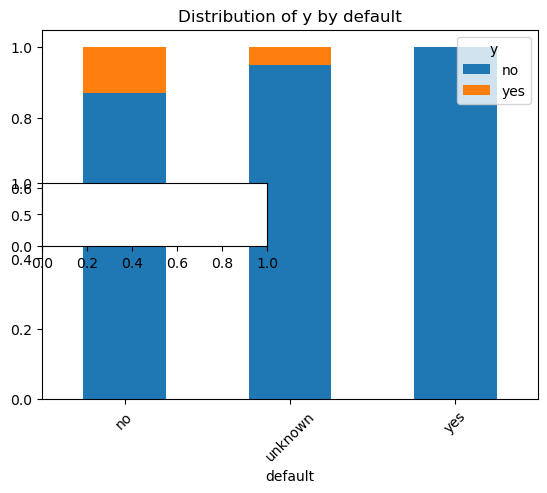

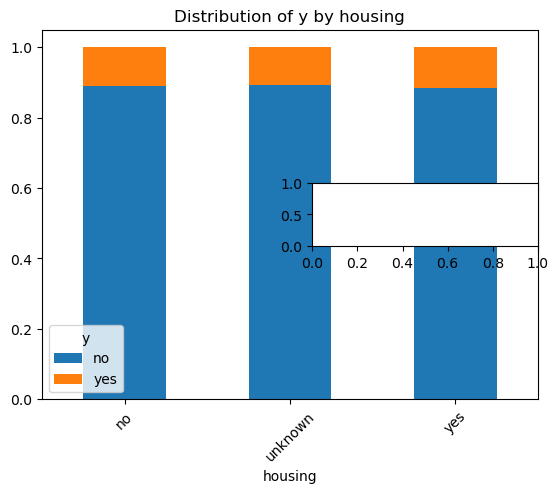

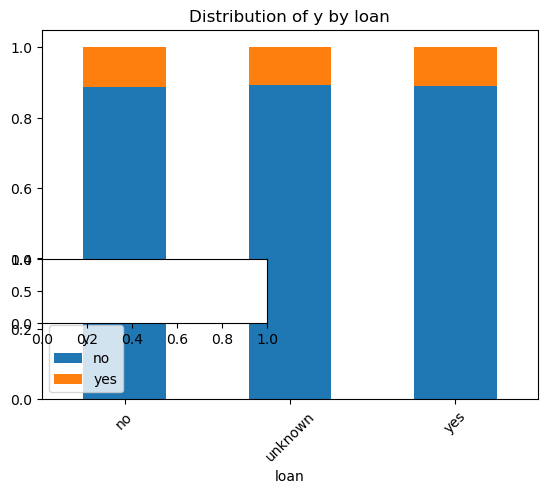

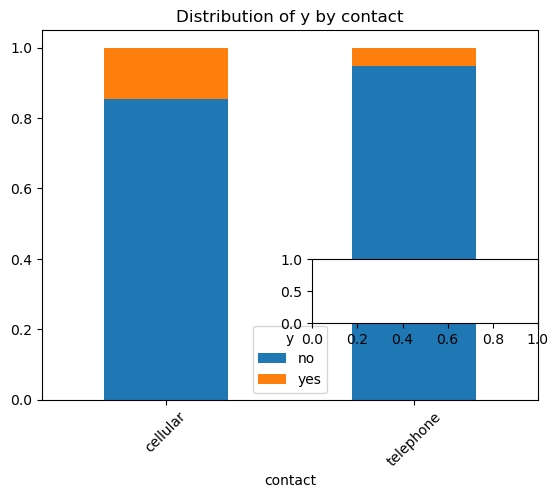

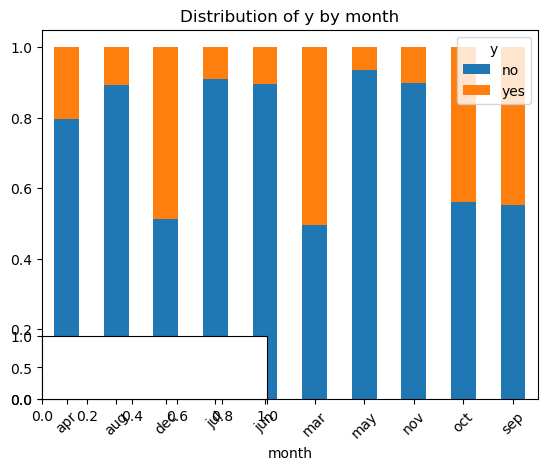

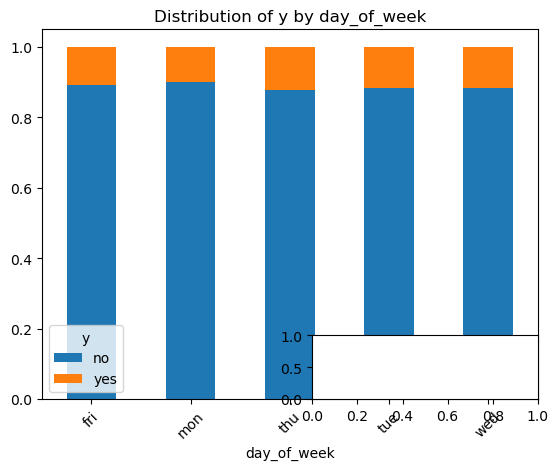

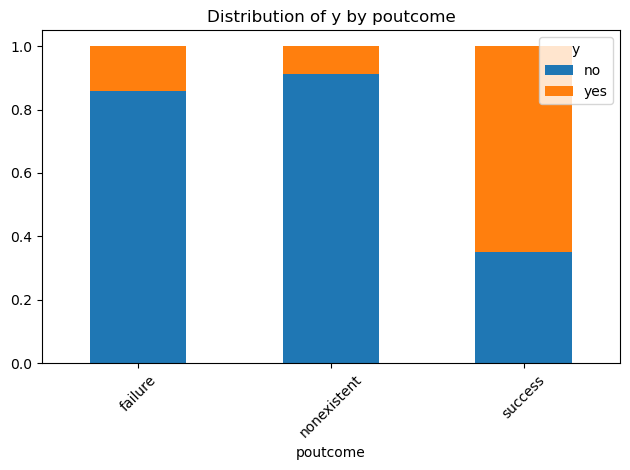

In [91]:
plot_categorical_distributions(data, cat_features)

In [83]:
generate_data_summary(data)

{'dataset_shape': (41188, 21),
 'numeric_features': {'count': 10,
  'names': ['age',
   'duration',
   'campaign',
   'pdays',
   'previous',
   'emp.var.rate',
   'cons.price.idx',
   'cons.conf.idx',
   'euribor3m',
   'nr.employed'],
  'statistics': {'age': {'count': 41188.0,
    'mean': 40.02406040594348,
    'std': 10.421249980934235,
    'min': 17.0,
    '25%': 32.0,
    '50%': 38.0,
    '75%': 47.0,
    'max': 98.0},
   'duration': {'count': 41188.0,
    'mean': 258.2850101971448,
    'std': 259.2792488364648,
    'min': 0.0,
    '25%': 102.0,
    '50%': 180.0,
    '75%': 319.0,
    'max': 4918.0},
   'campaign': {'count': 41188.0,
    'mean': 2.567592502670681,
    'std': 2.7700135429021127,
    'min': 1.0,
    '25%': 1.0,
    '50%': 2.0,
    '75%': 3.0,
    'max': 56.0},
   'pdays': {'count': 41188.0,
    'mean': 962.4754540157328,
    'std': 186.9109073447436,
    'min': 0.0,
    '25%': 999.0,
    '50%': 999.0,
    '75%': 999.0,
    'max': 999.0},
   'previous': {'count': 411

{'counts': {'no': 36548, 'yes': 4640},
 'distribution': {'no': 0.8873458288821987, 'yes': 0.11265417111780131},
 'imbalance_ratio': 0.127}


In [94]:
le = LabelEncoder()

In [95]:
le.fit_transform(data['y'])

array([0, 0, 0, ..., 0, 1, 0])

In [131]:
def encode_target(df: pd.DataFrame, target_column: str) -> Tuple[pd.DataFrame, LabelEncoder]:
    """
    Encode the target variable using LabelEncoder.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        target_column (str): Name of the target column
        
    Returns:
        Tuple[pd.DataFrame, LabelEncoder]: DataFrame with encoded target and the fitted encoder
    """
    df_encoded = df.copy()
    print(df_encoded.head(3))
    encoder = LabelEncoder()
    
    # Fit and transform the target variable
    df_encoded[target_column] = encoder.fit_transform(df[target_column])
    
    return df_encoded, encoder


In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [133]:
df, _ = encode_target(data, 'y')

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  

[3 rows x 21 columns]


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [137]:
df['y'].value_counts()

y
0    36548
1     4640
Name: count, dtype: int64

In [135]:
df2, _ = encode_categorical_features(df, cat_features)

In [121]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  int64  
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  int64  
 4   previous                       41188 non-null  int64  
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  y                              41188 non-null  int64  
 11  job_admin.                     41188 non-null  float64
 12  job_blue-collar                41188 non-null 

In [122]:
def preprocess_data(df: pd.DataFrame,
                    categorical_features: List[str],
                    numeric_features: List[str],
                    target_column: str) -> Tuple[pd.DataFrame, OneHotEncoder, StandardScaler, LabelEncoder]:
    """
    Preprocess the data by applying transformations in the correct order:
    1. Encode categorical features
    2. Scale numeric features
    3. Encode target variable
    
    Parameters:
        df (pd.DataFrame): Input dataset
        categorical_features (List[str]): List of categorical feature names
        numeric_features (List[str]): List of numerical feature names
        target_column (str): Name of the target column
        
    Returns:
        Tuple containing:
        - Preprocessed DataFrame
        - Fitted OneHotEncoder
        - Fitted StandardScaler
        - Fitted LabelEncoder
    """
    # 1. First encode categorical features
    df_processed, cat_encoder = encode_categorical_features(df, categorical_features)
    
    # 2. Then scale numeric features
    df_processed, num_scaler = preprocess_numeric_features(df_processed, numeric_features)
    
    # 3. Finally encode the target
    df_processed, target_encoder = encode_target(df_processed, target_column)
    
    return df_processed, cat_encoder, num_scaler, target_encoder

In [126]:
df, _, _ , _ = preprocess_data(data, cat_features, num_features, 'y')

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  float64
 1   duration                       41188 non-null  float64
 2   campaign                       41188 non-null  float64
 3   pdays                          41188 non-null  float64
 4   previous                       41188 non-null  float64
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  y                              41188 non-null  int64  
 11  job_admin.                     41188 non-null  float64
 12  job_blue-collar                41188 non-null 

In [129]:
cat_enc,_ = encode_categorical_features(data, cat_features)

In [130]:
cat_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  int64  
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  int64  
 4   previous                       41188 non-null  int64  
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  y                              41188 non-null  object 
 11  job_admin.                     41188 non-null  float64
 12  job_blue-collar                41188 non-null 

In [138]:
from sklearn.utils.class_weight import compute_class_weight

def compute_balanced_weights(y):
    """
    Compute balanced class weights for imbalanced target variable.
    
    Parameters:
        y: Target variable (encoded)
    Returns:
        dict: Dictionary with class weights
    """
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y),
        y=y
    )
    return dict(zip(np.unique(y), class_weights))

In [139]:
compute_balanced_weights(data['y'])

{'no': 0.5634781656999015, 'yes': 4.438362068965517}

In [140]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def handle_imbalanced_data(df: pd.DataFrame, 
                          target_column: str,
                          strategy: str = 'smote') -> pd.DataFrame:
    """
    Handle imbalanced dataset using various techniques.
    
    Parameters:
        df (pd.DataFrame): Preprocessed dataframe
        target_column (str): Name of target column
        strategy (str): Resampling strategy ('smote', 'undersample', or 'combine')
        
    Returns:
        pd.DataFrame: Resampled dataframe
    """
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    if strategy == 'smote':
        # Use SMOTE to oversample minority class
        sampler = SMOTE(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X, y)
    
    elif strategy == 'undersample':
        # Undersample majority class
        sampler = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X, y)
    
    elif strategy == 'combine':
        # Combine SMOTE with undersampling
        over = SMOTE(sampling_strategy=0.5, random_state=42)  # Oversample to 50% ratio
        under = RandomUnderSampler(sampling_strategy=0.75, random_state=42)  # Further balance
        pipeline = Pipeline([('over', over), ('under', under)])
        X_resampled, y_resampled = pipeline.fit_resample(X, y)
    
    # Reconstruct dataframe
    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled[target_column] = y_resampled
    
    return df_resampled

In [141]:
def preprocess_data(df: pd.DataFrame,
                    categorical_features: List[str],
                    numeric_features: List[str],
                    target_column: str,
                    handle_imbalance: str = None
                   ) -> Tuple[pd.DataFrame, OneHotEncoder, StandardScaler, LabelEncoder]:
    """
    Enhanced preprocessing pipeline that handles class imbalance.
    
    Parameters:
        df (pd.DataFrame): Input dataset
        categorical_features (List[str]): List of categorical feature names
        numeric_features (List[str]): List of numerical feature names
        target_column (str): Name of the target column
        handle_imbalance (str): Strategy for handling imbalance ('smote', 'undersample', 'combine', or None)
        
    Returns:
        Tuple containing:
        - Preprocessed DataFrame
        - Fitted OneHotEncoder
        - Fitted StandardScaler
        - Fitted LabelEncoder
    """
    # 1. First encode categorical features
    df_processed, cat_encoder = encode_categorical_features(df, categorical_features)
    
    # 2. Then scale numeric features
    df_processed, num_scaler = preprocess_numeric_features(df_processed, numeric_features)
    
    # 3. Encode the target
    df_processed, target_encoder = encode_target(df_processed, target_column)
    
    # 4. Handle class imbalance if specified
    if handle_imbalance:
        df_processed = handle_imbalanced_data(df_processed, target_column, handle_imbalance)
    
    return df_processed, cat_encoder, num_scaler, target_encoder

In [146]:
# datasets.load_digits()